# Rule-based matching

Find phrases and tokens, and match entities

Compared to using regular expressions on raw text, spaCy’s rule-based matcher engines and components not only let you find the words and phrases you’re looking for – they also give you access to the tokens within the document and their relationships. This means you can easily access and analyze the surrounding tokens, merge spans into single tokens or add entries to the named entities in doc.ents.

<h3> Should I use rules or train a model? </h3>

For complex tasks, it’s usually better to train a statistical entity recognition model. <mark>However, statistical models require training data,</mark> so for many situations, **rule-based approaches are more practical.** ***This is especially true at the start of a project: you can use a rule-based approach as part of a data collection process, to help you “bootstrap” a statistical model.***

Training a model is useful if you have some examples and you want your system to be able to generalize based on those examples. It works especially well if there are clues in the local context. For instance, if you’re trying to detect person or company names, your application may benefit from a statistical named entity recognition model.

Rule-based systems are a good choice if there’s a more or less finite number of examples that you want to find in the data, **or if there’s a very clear, structured pattern you can express with token rules or regular expressions.** For instance, country names, IP addresses or URLs are things you might be able to handle well with a purely rule-based approach.

You can also combine both approaches and improve a statistical model with rules to handle very specific cases and boost accuracy. For details, see the section on rule-based entity recognition.

<h3>When should I use token matcher vs. the phrase matcher? </h3>

The PhraseMatcher is useful if you already have a large terminology list or gazetteer consisting of single or multi-token phrases that you want to find exact instances of in your data. As of spaCy v2.1.0, you can also match on the LOWER attribute for fast and case-insensitive matching.

The Matcher isn’t as blazing fast as the PhraseMatcher, since it compares across individual token attributes. However, it allows you to write very abstract representations of the tokens you’re looking for, using lexical attributes, linguistic features predicted by the model, operators, set membership and rich comparison. For example, you can find a noun, followed by a verb with the lemma “love” or “like”, followed by an optional determiner and another token that’s at least 10 characters long.

>Traduzido:

O **PhraseMatcher** é útil se você já tiver uma grande lista de terminologia ou dicionário geográfico que consiste em frases de um ou vários tokens das quais deseja encontrar instâncias exatas em seus dados. A partir do spaCy v2.1.0, você também pode fazer correspondência no atributo LOWER para uma correspondência rápida e sem distinção entre maiúsculas e minúsculas.

O Matcher não é tão rápido quanto o PhraseMatcher, pois compara atributos de tokens individuais. No entanto, ele permite que você escreva representações muito abstratas dos tokens que você está procurando, usando atributos lexicais, recursos linguísticos previstos pelo modelo, operadores, associação de conjunto e comparação rica. Por exemplo, você pode encontrar um substantivo, seguido por um verbo com o lema “amor” ou “gostar”, seguido por um determinante opcional e outro token com pelo menos 10 caracteres.

<hr>

## 1. Token-based matching

spaCy features a rule-matching engine, the Matcher, that operates over tokens, similar to regular expressions. The rules can refer to token annotations (e.g. the token text or tag_, and flags like IS_PUNCT). The rule matcher also lets you pass in a custom callback to act on matches – for example, to merge entities and apply custom labels. You can also associate patterns with entity IDs, to allow some basic entity linking or disambiguation. To match large terminology lists, you can use the PhraseMatcher, which accepts Doc objects as match patterns.

Let’s say we want to enable spaCy to find a combination of three tokens:

    1. A token whose lowercase form matches “hello”, e.g. “Hello” or “HELLO”.
    2. A token whose is_punct flag is set to True, i.e. any punctuation.
    3. A token whose lowercase form matches “world”, e.g. “World” or “WORLD”.

In [ ]:
[{"LOWER": "hello"}, {"IS_PUNCT": True}, {"LOWER": "world"}]

<mark>Important - making patterns </mark>

When writing patterns, keep in mind that each dictionary represents one token. If spaCy’s tokenization doesn’t match the tokens defined in a pattern, the pattern is not going to produce any results. When developing complex patterns, make sure to check examples against spaCy’s tokenization:

In [ ]:
doc = nlp("A complex-example,!")
print([token.text for token in doc])

First, we initialize the Matcher with a vocab. The matcher must always share the same vocab with the documents it will operate on. 

In [1]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

We can now call matcher.add() with an ID and a list of patterns.

In [2]:

# Add match ID "HelloWorld" with no callback and one pattern
pattern = [{"LOWER": "hello"}, {"IS_PUNCT": True}, {"LOWER": "world"}]
matcher.add("HelloWorld", [pattern])



The matcher returns a list of (match_id, start, end) tuples – in this case, [('15578876784678163569', 0, 3)], which maps to the span doc[0:3] of our original document. The match_id is the hash value of the string ID “HelloWorld”. To get the string value, you can look up the ID in the StringStore.

In [3]:
doc = nlp("Hello, world! Hello world!")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

15578876784678163569 HelloWorld 0 3 Hello, world


Optionally, we could also choose to add more than one pattern, for example to also match sequences without punctuation between “hello” and “world”:

In [4]:
patterns = [
    [{"LOWER": "hello"}, {"IS_PUNCT": True}, {"LOWER": "world"}],
    [{"LOWER": "hello"}, {"LOWER": "world"}]
]
matcher.add("HelloWorld", patterns)

By default, the matcher will only return the matches and not do anything else, like merge entities or assign labels. This is all up to you and can be defined individually for each pattern, by passing in a callback function as the on_match argument on add(). This is useful, because it lets you write entirely custom and pattern-specific logic. For example, you might want to merge some patterns into one token, while adding entity labels for other pattern types. You shouldn’t have to create different matchers for each of those processes.

<h3>Available token attributes</h3>

The available token pattern keys correspond to a number of Token attributes. The supported attributes for rule-based matching are:

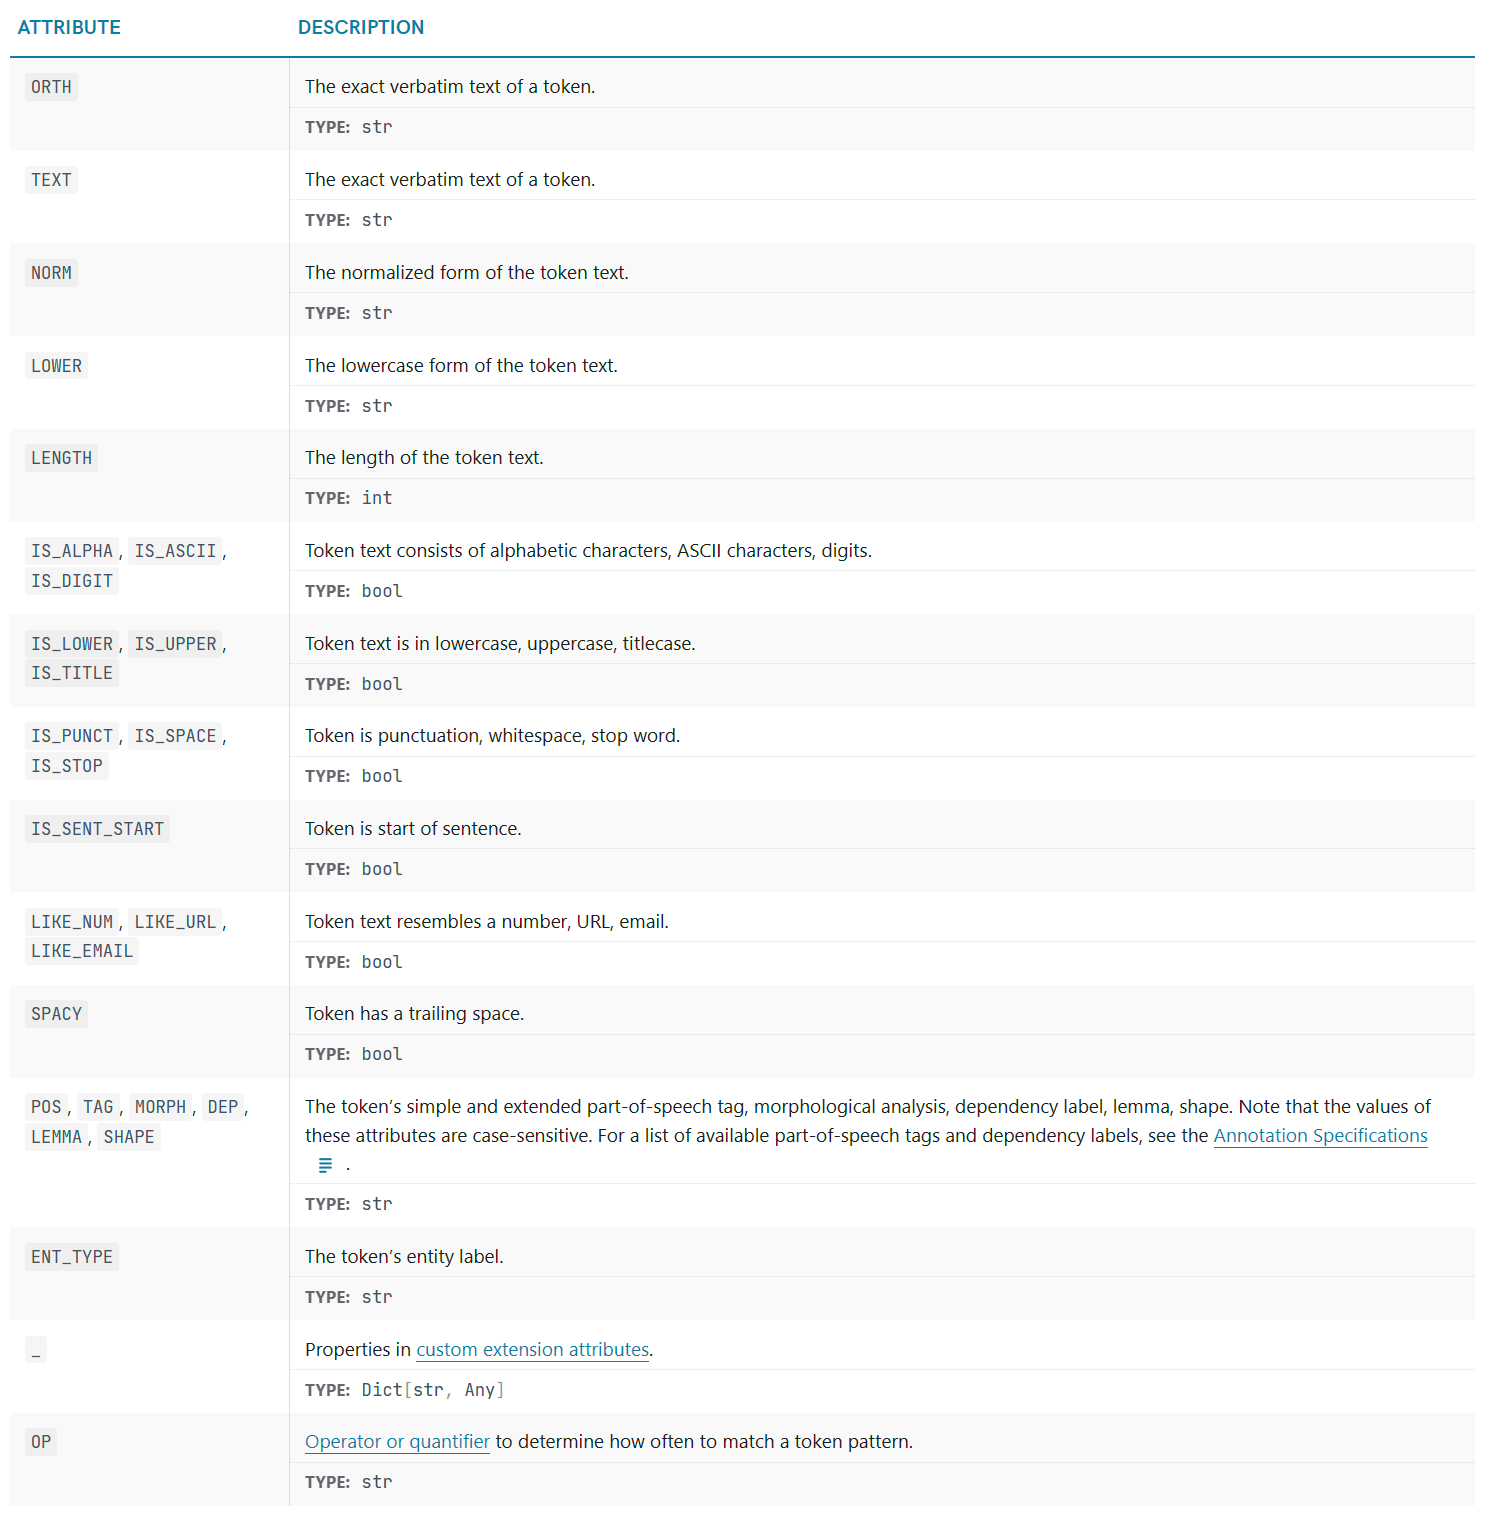

<h3>Does it matter if the atribute name is uppercase or lowercase?</h3>

No, it shouldn’t. spaCy will normalize the names internally and {"LOWER": "text"} and {"lower": "text"} will both produce the same result. Using the uppercase version is mostly a convention to make it clear that the attributes are “special” and don’t exactly map to the token attributes like Token.lower and Token.lower_.

<h3>Why are not all token attributes supported?</h3>

spaCy can’t provide access to all of the attributes because the Matcher loops over the Cython data, not the Python objects. Inside the matcher, we’re dealing with a TokenC struct – we don’t have an instance of Token. This means that all of the attributes that refer to computed properties can’t be accessed.

The uppercase attribute names like LOWER or IS_PUNCT refer to symbols from the spacy.attrs enum table. They’re passed into a function that essentially is a big case/switch statement, to figure out which struct field to return. The same attribute identifiers are used in Doc.to_array, and a few other places in the code where you need to describe fields like this.

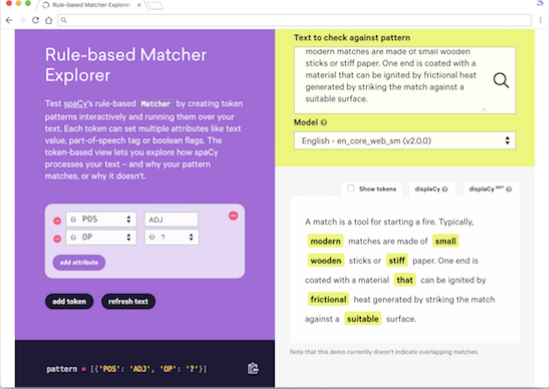


https://demos.explosion.ai/matcher?text=Hello.%20world!%20Hello%20world%20and%20hello%202%20world!&model=en_core_web_sm&pattern=%5B%7B%22id%22%3A1%2C%22attrs%22%3A%5B%7B%22name%22%3A%22LENGTH%22%2C%22value%22%3A%223%22%7D%5D%7D%5D

Extended pattern syntax and attributes

Instead of mapping to a single value, token patterns can also map to a dictionary of properties. For example, to specify that the value of a lemma should be part of a list of values, or to set a minimum character length. The following rich comparison attributes are available:

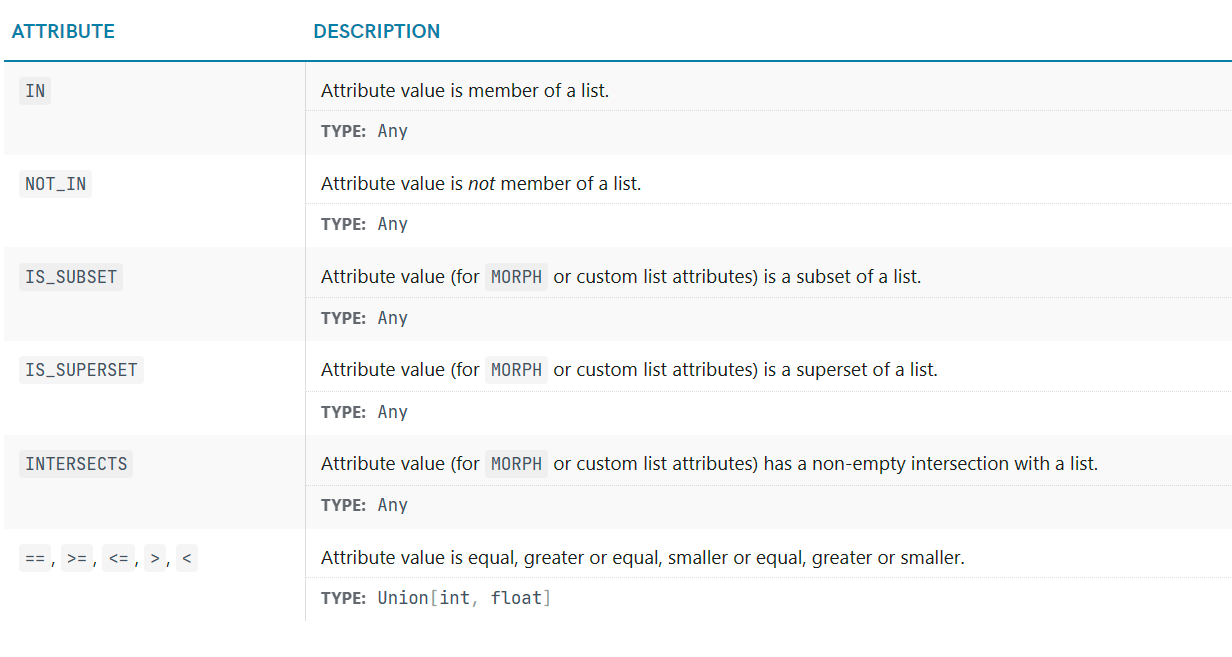

In [5]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import pandas as pd
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

>Pattern 1

In [6]:
# Matches "love cats" or "likes flowers"
pattern1 = [{"LEMMA": {"IN": ["like", "love"]}},
            {"POS": "NOUN"}]

In [7]:
matcher.add("LIKE", [pattern1])

In [8]:
doc = nlp("I love cats")
matches = matcher(doc)

>Pattern 2

In [9]:
# Matches tokens of length >= 9
pattern2 = [{"LENGTH": {">=": 9}}]

In [10]:
matcher.add("LEN", [pattern2])

In [11]:
len(matcher)

2

In [12]:
doc = nlp("I have a snowboard so cool man!")
matches = matcher(doc)

>Pattern 3

In [13]:
# Match based on morph attributes
pattern3 = [{"MORPH": {"IS_SUBSET": ["Number=Sing", "Gender=Neut"]}}]


# "", "Number=Sing" and "Number=Sing|Gender=Neut" will match as subsets
# "Number=Plur|Gender=Neut" will not match
# "Number=Sing|Gender=Neut|Polite=Infm" will not match because it's a superset

In [14]:
matcher.add("COMPLEX", [pattern3])

In [15]:
len(matcher)

3

In [16]:
doc = nlp("I have a snowboard so cool man and I love cats!")
matches = matcher(doc)

>Result and render

In [17]:
# POS Tagging
morph_analisys = pd.DataFrame(data=[], \
  columns=["id", "T_texto","T_lemma_", "T_pos_", "T_tag_", "T_dep_", "T_shape_", "T_is_alpha", "T_is_stop"])
i = 0
for token in doc:
    morph_analisys.loc[i,"id"] = token.i
    morph_analisys.loc[i,"T_texto"] = token.text
    morph_analisys.loc[i,"T_lemma_"] = token.lemma_
    morph_analisys.loc[i,"T_pos_"] = token.pos_
    morph_analisys.loc[i,"T_tag_"] = token.tag_
    morph_analisys.loc[i,"T_dep_"] = token.dep_
    morph_analisys.loc[i,"T_shape_"] = token.shape_
    morph_analisys.loc[i,"T_is_alpha"] = token.is_alpha
    morph_analisys.loc[i,"T_is_stop"] = token.is_stop

    i = i+1

morph_analisys

,id,T_texto,T_lemma_,T_pos_,T_tag_,T_dep_,T_shape_,T_is_alpha,T_is_stop
0,0,I,I,PRON,PRP,nsubj,X,True,True
1,1,have,have,VERB,VBP,ROOT,xxxx,True,True
2,2,a,a,DET,DT,det,x,True,True
3,3,snowboard,snowboard,NOUN,NN,dobj,xxxx,True,False
4,4,so,so,ADV,RB,advmod,xx,True,True
5,5,cool,cool,ADJ,JJ,amod,xxxx,True,False
6,6,man,man,NOUN,NN,dobj,xxx,True,False
7,7,and,and,CCONJ,CC,cc,xxx,True,True
8,8,I,I,PRON,PRP,nsubj,X,True,True
9,9,love,love,VERB,VBP,conj,xxxx,True,False


In [18]:
# 1. Return (match_id, start, end) tuples
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    #span = doc[start:end]  # The matched span
    span = Span(doc, start, end, label=match_id)
    print(f'match_id: {match_id:>20} | string_id: {string_id:>10} | start: {start} | end: {end} | span.text: {span.text:>12} | span.label_: {span.label_}')

    
    colors = {"LEN": "red"}
    options = {"span": ["LEN"], "colors": colors}

    colors = {"COMPLEX": "blue"}
    options = {"span": ["COMPLEX"], "colors": colors}
        

    doc.spans["sc"] = [
    Span(doc, start, end, "LEN"),
    Span(doc, start, end, "COMPLEX"),
    Span(doc, start, end, "LIKE"),
    ]

    displacy.render(doc, style="span", options=options)  
            

match_id: 15616739437835610435 | string_id:        LEN | start: 3 | end: 4 | span.text:    snowboard | span.label_: LEN


match_id:  3268819397087565709 | string_id:    COMPLEX | start: 3 | end: 4 | span.text:    snowboard | span.label_: COMPLEX


match_id:  3268819397087565709 | string_id:    COMPLEX | start: 4 | end: 5 | span.text:           so | span.label_: COMPLEX


match_id:  3268819397087565709 | string_id:    COMPLEX | start: 6 | end: 7 | span.text:          man | span.label_: COMPLEX


match_id:  3008561262359433857 | string_id:       LIKE | start: 9 | end: 11 | span.text:    love cats | span.label_: LIKE


### Regular expressions

In some cases, only matching tokens and token attributes isn’t enough – for example, you might want to match different spellings of a word, without having to add a new pattern for each spelling.

In [19]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import pandas as pd
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

In [20]:
pattern = [{"TEXT": {"REGEX": "^[Uu](\\.?|nited)$"}},
           {"TEXT": {"REGEX": "^[Ss](\\.?|tates)$"}},
           {"LOWER": "president"}]

In [21]:
matcher.add("PRESIDENT", [pattern])

In [22]:
doc = nlp("The United States president made a speech this morning!")
matches = matcher(doc)

In [23]:
doc = nlp("The united states president made a speech this morning!")
matches = matcher(doc)

In [24]:
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    #span = doc[start:end]  # The matched span
    span = Span(doc, start, end, label="US_IMPOTANT_PERSON")
    print(f'match_id: {match_id:>20} | string_id: {string_id:>10} | start: {start} | end: {end} | span.text: {span.text:>12} | span.label_: {span.label_}')

match_id: 12999748546397611138 | string_id:  PRESIDENT | start: 1 | end: 4 | span.text: united states president | span.label_: US_IMPOTANT_PERSON


In [25]:
displacy.render(doc, style="ent", options=options) 

In [26]:
# 2. Return Span objects directly
matches = matcher(doc, as_spans=True)
for span in matches:
    print(span.text, span.label_)

    colors = {"US_IMPOTANT_PERSON": "green"}
    options = {"span": ["US_IMPOTANT_PERSON"], "colors": colors}
    doc.spans["sc"] = [
    Span(doc, start, end, "US_IMPOTANT_PERSON"),
    ]

    displacy.render(doc, style="span", options=options)      

united states president PRESIDENT


The REGEX operator allows defining rules for any attribute string value, including custom attributes. It always needs to be applied to an attribute like TEXT, LOWER or TAG:

In [27]:
# Match different spellings of token texts
pattern = [{"TEXT": {"REGEX": "deff?in[ia]tely"}}]

# Match tokens with fine-grained POS tags starting with 'V'
pattern = [{"TAG": {"REGEX": "^V"}}]

# Match custom attribute values with regular expressions
pattern = [{"_": {"country": {"REGEX": "^[Uu](nited|\\.?) ?[Ss](tates|\\.?)$"}}}]

<h3>Matching regular expressions on the full text</h3>

If your expressions apply to multiple tokens, a simple solution is to match on the doc.text with re.finditer and use the Doc.char_span method to create a Span from the character indices of the match. If the matched characters don’t map to one or more valid tokens, Doc.char_span returns None.

In [28]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")
doc = nlp("The United States of America (USA) are commonly known as the United States (U.S. or US) or America.")

expression = r"[Uu](nited|\\.?) ?[Ss](tates|\\.?)"
for match in re.finditer(expression, doc.text):
    start, end = match.span()
    span = doc.char_span(start, end)
    # This is a Span object or None if match doesn't map to valid token sequence
    if span is not None:
        print("Found match:", span.text, span.ent_id_, span.start, span.end)

Found match: United States  1 3
Found match: United States  13 15


<h3>How can I expand the match to a valid token sequence?</h3>

In some cases, you might want to expand the match to the closest token boundaries, so you can create a Span for "USA", even though only the substring "US" is matched. You can calculate this using the character offsets of the tokens in the document, available as Token.idx. This lets you create a list of valid token start and end boundaries and leaves you with a rather basic algorithmic problem: Given a number, find the next lowest (start token) or the next highest (end token) number that’s part of a given list of numbers. This will be the closest valid token boundary.

There are many ways to do this and the most straightforward one is to create a dict keyed by characters in the Doc, mapped to the token they’re part of. It’s easy to write and less error-prone, and gives you a constant lookup time: you only ever need to create the dict once per Doc.

In [ ]:
import spacy
import re
from spacy.matcher import Matcher
from spacy.tokens import Span
import pandas as pd
from spacy import displacy

nlp = spacy.load("en_core_web_sm")


In [ ]:
doc = nlp("The uni state of America (USA) are commonly known as the united State (U.S. or US) or America - uni state, state")

In [ ]:
# expression = r"[Uu](nited|\\.?) ?[Ss](tates|\\.?)"
expression = r"[Uu](ni|\\.?) ?[Ss](tat|\\.?)[es]"

In [ ]:
for match in re.finditer(expression, doc.text):
    start, end = match.span()
    span = doc.char_span(start, end)
    # This is a Span object or None if match doesn't map to valid token sequence
    if span is not None:
        print("Found match:", span.text, span.ent_id_, span.start, span.end, "Texto correto: Uni State")

In [ ]:
chars_to_tokens = {}
for token in doc:
    for i in range(token.idx, token.idx + len(token.text)):
        chars_to_tokens[i] = token.i

In [ ]:
tokens_id_text = {}
for token in doc:
    tokens_id_text[token.i] = token.text

In [ ]:
tokens_id_text

In [ ]:
tokens_id = []
for token in doc:
    tokens_id.append(token.i)

In [ ]:
tokens_id

In [ ]:
chars_to_tokens

You can then look up character at a given position, and get the index of the corresponding token that the character is part of. Your span would then be doc[token_start:token_end]. If a character isn’t in the dict, it means it’s the (white)space tokens are split on. That hopefully shouldn’t happen, though, because it’d mean your regex is producing matches with leading or trailing whitespace.

In [ ]:
span = doc.char_span(start, end)
teste = False
if teste:
    print("Found match:", span.text, span.ent_id_, span.start, span.end)
else:
    start_token = chars_to_tokens.get(start)
    end_token = chars_to_tokens.get(end)
    if start_token is not None and end_token is not None:
        span = doc[start_token:end_token + 1]
        print("Found closest match:", span.text, span.start, span.end)

### Fuzzy matching

Fuzzy matching allows you to match tokens with alternate spellings, typos, etc. without specifying every possible variant.

In [ ]:
# Matches "favourite", "favorites", "gavorite", "theatre", "theatr", ...
pattern = [{"TEXT": {"FUZZY": "favorite"}},
           {"TEXT": {"FUZZY": "theater"}}]

The FUZZY attribute allows fuzzy matches for any attribute string value, including custom attributes. Just like REGEX, it always needs to be applied to an attribute like TEXT or LOWER. By default FUZZY allows a Levenshtein edit distance of at least 2 and up to 30% of the pattern string length. Using the more specific attributes FUZZY1..FUZZY9 you can specify the maximum allowed edit distance directly.

In [ ]:
# Match lowercase with fuzzy matching (allows 3 edits)
pattern = [{"LOWER": {"FUZZY": "definitely"}}]

# Match custom attribute values with fuzzy matching (allows 3 edits)
pattern = [{"_": {"country": {"FUZZY": "Kyrgyzstan"}}}]

# Match with exact Levenshtein edit distance limits (allows 4 edits)
pattern = [{"_": {"country": {"FUZZY4": "Kyrgyzstan"}}}]

<h3>Test in portuguese</h3>

In [ ]:
import spacy
import pandas as pd

nlp = spacy.load("pt_core_news_lg")


In [ ]:
text = "A Companhia das Letras lançou novos livros para este inverno"
doc1 = nlp(text)

In [ ]:
[(token.i, token.text) for token in doc1]

In [ ]:
tokens_to_check = [0, 1, 2, 3]

tokens_to_check


In [ ]:
doc = doc1
print(doc)
text_ruler = pd.DataFrame(data=[], \
  columns=["T_idx", "T_texto","T_Tag_", "T_Tag_explained", "T_pos_", "T_pos_explained"])
i = 0
for idx in tokens_to_check:
    text_ruler.loc[i,"T_idx"] = doc[idx].i
    text_ruler.loc[i,"T_texto"] = doc[idx].text
    text_ruler.loc[i,"T_Tag_"] = doc[idx].tag_
    text_ruler.loc[i,"T_Tag_explained"] = spacy.explain(doc[idx].tag_)
    text_ruler.loc[i,"T_pos_"] = doc[idx].pos_
    text_ruler.loc[i,"T_pos_explained"] = spacy.explain(doc[idx].pos_)
 
    
    i = i+1
text_ruler

In [ ]:
# Add attribute ruler with exception for "A Santa Rita" as NNP/PROPN NNP/PROPN
ruler = nlp.get_pipe("attribute_ruler")

In [ ]:
pattern = [{"TEXT": {"FUZZY": {"IN": ["contrato", "contratos", "contract"]}}}]

In [ ]:
# Pattern to match "A Santa Rita"
patterns = [[{"TEXT": {"FUZZY": "Companhia"}}, {"LOWER": "das"}, {"TEXT": {"FUZZY": "Letras"}}]]
# The attributes to assign to the matched token
attrs = {"TAG": "NNP", "POS": "PROPN"}
# Add rules to the attribute ruler

In [ ]:
# Add rules to the attribute ruler
ruler.add(patterns=patterns, attrs=attrs, index=0)  # "A" em "A Santa Rita"
ruler.add(patterns=patterns, attrs=attrs, index=1)  # "Santa" em "A Santa Rita"
ruler.add(patterns=patterns, attrs=attrs, index=2)

In [ ]:
# Matches "favourite", "favorites", "gavorite", "theatre", "theatr", ...
pattern = [{"TEXT": {"FUZZY": "favorite"}},
           {"TEXT": {"FUZZY": "theater"}}]

In [ ]:
doc2 = nlp(text)

In [ ]:
text = "A Compania das Letra lançou novos livros para este inverno"
doc2 = nlp(text)

In [ ]:
doc = doc2
print(doc)
text_ruler = pd.DataFrame(data=[], \
  columns=["T_idx", "T_texto","T_Tag_", "T_Tag_explained", "T_pos_", "T_pos_explained"])
i = 0
for idx in tokens_to_check:
    text_ruler.loc[i,"T_idx"] = doc[idx].i
    text_ruler.loc[i,"T_texto"] = doc[idx].text
    text_ruler.loc[i,"T_Tag_"] = doc[idx].tag_
    text_ruler.loc[i,"T_Tag_explained"] = spacy.explain(doc[idx].tag_)
    text_ruler.loc[i,"T_pos_"] = doc[idx].pos_
    text_ruler.loc[i,"T_pos_explained"] = spacy.explain(doc[idx].pos_)
 
    
    i = i+1
text_ruler

<h3>Regex and fuzzy matching with lists</h3>

Starting in spaCy v3.5, both REGEX and FUZZY can be combined with the attributes IN and NOT_IN:

In [ ]:
pattern = [{"TEXT": {"FUZZY": {"IN": ["awesome", "cool", "wonderful"]}}}]

pattern = [{"TEXT": {"REGEX": {"NOT_IN": ["^awe(some)?$", "^wonder(ful)?"]}}}]

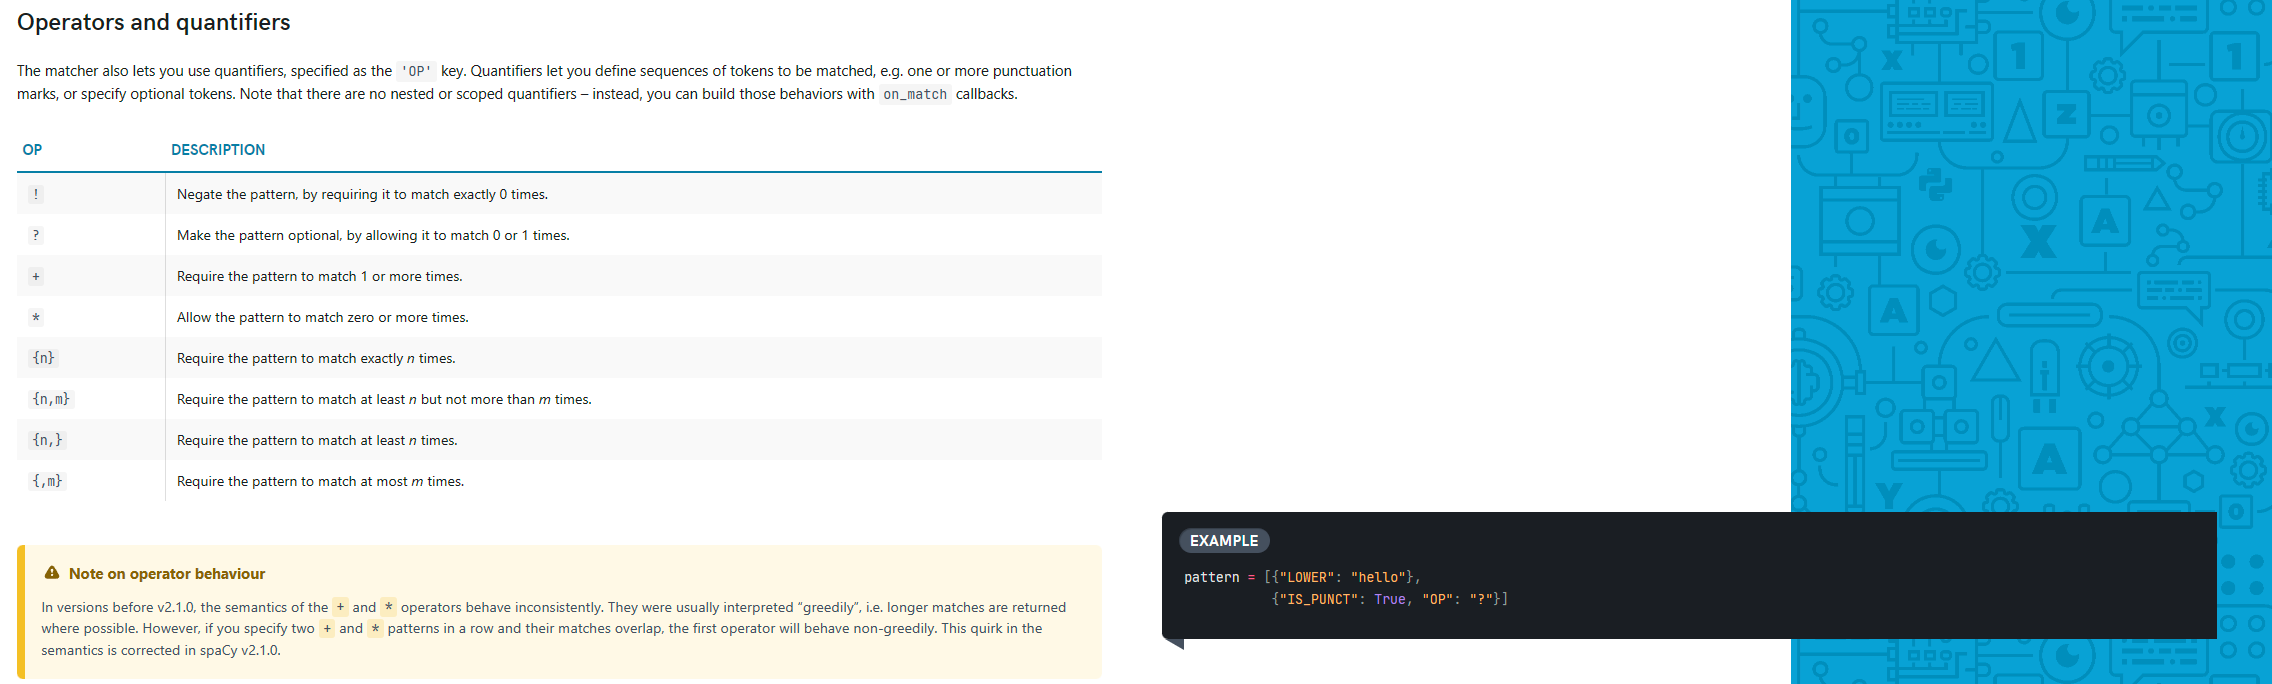

<h3>Using wildcard token patterns</h3>

While the token attributes offer many options to write highly specific patterns, you can also use an empty dictionary, {} as a wildcard representing any token. This is useful if you know the context of what you’re trying to match, but very little about the specific token and its characters. For example, let’s say you’re trying to extract people’s user names from your data. All you know is that they are listed as “User name: {username}“. The name itself may contain any character, but no whitespace – so you’ll know it will be handled as one token.

<h3>Validating and debugging patterns </h3>

The Matcher can validate patterns against a JSON schema with the option validate=True. This is useful for debugging patterns during development, in particular for catching unsupported attributes.

In [ ]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab, validate=True)
# Add match ID "HelloWorld" with unsupported attribute CASEINSENSITIVE
pattern = [{"LOWER": "hello"}, {"IS_PUNCT": True}, {"CASEINSENSITIVE": "world"}]
matcher.add("HelloWorld", [pattern])
# 🚨 Raises an error:
# MatchPatternError: Invalid token patterns for matcher rule 'HelloWorld'
# Pattern 0:
# - [pattern -> 2 -> CASEINSENSITIVE] extra fields not permitted

### Adding on_match rules

To move on to a more realistic example, let’s say you’re working with a large corpus of blog articles, and you want to match all mentions of “Google I/O” (which spaCy tokenizes as ['Google', 'I', '/', 'O']). To be safe, you only match on the uppercase versions, avoiding matches with phrases such as “Google i/o”.

In [ ]:
from spacy.lang.en import English
from spacy.matcher import Matcher
from spacy.tokens import Span

In [ ]:
nlp = English()
matcher = Matcher(nlp.vocab)

In [ ]:
def add_event_ent(matcher, doc, i, matches):
    # Get the current match and create tuple of entity label, start and end.
    # Append entity to the doc's entity. (Don't overwrite doc.ents!)
    match_id, start, end = matches[i]
    entity = Span(doc, start, end, label="EVENT")
    doc.ents += (entity,)
    print(entity.text, entity.label_)

In [ ]:
pattern = [{"ORTH": "Google"}, {"ORTH": "I"}, {"ORTH": "/"}, {"ORTH": "O"}]
matcher.add("GoogleIO", [pattern], on_match=add_event_ent)


In [ ]:
doc = nlp("This is a text about Google I/O")

In [ ]:
matches = matcher(doc)

In [ ]:
from spacy import displacy

displacy.render(doc, style='ent',
                jupyter=True, options={'distance': 120})

<h3>Portuguese</h>

In [9]:
from spacy.lang.pt import Portuguese
from spacy.matcher import Matcher
from spacy.tokens import Span

In [10]:
nlp = Portuguese()
matcher = Matcher(nlp.vocab)

In [11]:
def add_event_ent(matcher, doc, i, matches):
    # Get the current match and create tuple of entity label, start and end.
    # Append entity to the doc's entity. (Don't overwrite doc.ents!)
    match_id, start, end = matches[i]
    entity = Span(doc, start, end, label="FAZENDA")
    doc.ents += (entity,)
    print(entity.text, entity.label_)

In [12]:
pattern = [{"ORTH": "Santa"}, {"ORTH": "Rita"}]
matcher.add("SantaRita", [pattern], on_match=add_event_ent)

In [13]:
doc = nlp("Estamos nos aproximando da fazenda Santa Rita.")

In [14]:
matches = matcher(doc)

Santa Rita FAZENDA


In [15]:
from spacy import displacy
html = displacy.render(doc, style="ent", page=True,
                       options={"ents": ["FAZENDA"]})

In [ ]:
# Pattern to match "A Santa Rita"
patterns = [[{"TEXT": {"FUZZY": "Companhia"}}, {"LOWER": "das"}, {"TEXT": {"FUZZY": "Letras"}}]]
# The attributes to assign to the matched token
attrs = {"TAG": "NNP", "POS": "PROPN"}
# Add rules to the attribute ruler

In [ ]:
# Add rules to the attribute ruler
ruler.add(patterns=patterns, attrs=attrs, index=0)  # "A" em "A Santa Rita"
ruler.add(patterns=patterns, attrs=attrs, index=1)  # "Santa" em "A Santa Rita"
ruler.add(patterns=patterns, attrs=attrs, index=2)

### Creating spans from matches

Creating Span objects from the returned matches is a very common use case. spaCy makes this easy by giving you access to the start and end token of each match, which you can use to construct a new span with an optional label. As of spaCy v3.0, you can also set as_spans=True when calling the matcher on a Doc, which will return a list of Span objects using the match_id as the span label.

In [ ]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy import displacy

nlp = spacy.blank("en")
matcher = Matcher(nlp.vocab)

In [ ]:
matcher.add("PERSON", [[{"lower": "barack"}, {"lower": "obama"}]])
doc = nlp("Barack Obama from United States was the 44th president.")

In [ ]:
# 1. Return (match_id, start, end) tuples
matches = matcher(doc)
for match_id, start, end in matches:
    # Create the matched span and assign the match_id as a label
    span = Span(doc, start, end, label=match_id)
    print(span.text, span.label_)

In [ ]:
# 2. Return Span objects directly
matches = matcher(doc, as_spans=True)
for span in matches:
    print(span.text, span.label_, span.start, span.end)

In [ ]:
# 2. Return Span objects directly
matches = matcher(doc, as_spans=True)
for span in matches:
    doc.spans["sc"] = [
    Span(doc, span.start, span.end, "PERSON"),
    Span(doc, 3, 5, "GPE"),]
displacy.render(doc, style="span")    


In [ ]:
# 2. Return Span objects directly
matches = matcher(doc, as_spans=True)
for span in matches:
    doc.spans["sc"] = [
    Span(doc, 0, 5, "PERSON"),
    Span(doc, 3, 5, "GPE"),]
displacy.render(doc, style="span")    


In [ ]:
import spacy
from spacy import displacy
from spacy.tokens import Span

text = "Welcome to the Bank of China."

nlp = spacy.blank("en")
doc = nlp(text)

doc.spans["sc"] = [
    Span(doc, 3, 6, "ORG"),
    Span(doc, 5, 6, "GPE"),
]

displacy.render(doc, style="span")

### <mark>Using custom pipeline components</mark>

Let’s say your data also contains some annoying pre-processing artifacts, like leftover HTML line breaks (e.g. <br> or <BR/>). To make your text easier to analyze, you want to merge those into one token and flag them, to make sure you can ignore them later. Ideally, this should all be done automatically as you process the text. You can achieve this by adding a custom pipeline component that’s called on each Doc object, merges the leftover HTML spans and sets an attribute bad_html on the token.

In [1]:
import spacy
from spacy.language import Language
from spacy.matcher import Matcher
from spacy.tokens import Token

In [2]:
# We're using a component factory because the component needs to be
# initialized with the shared vocab via the nlp object
@Language.factory("html_merger")
def create_bad_html_merger(nlp, name):
    return BadHTMLMerger(nlp.vocab)

class BadHTMLMerger:
    def __init__(self, vocab):
        patterns = [
            [{"ORTH": "<"}, {"LOWER": "br"}, {"ORTH": ">"}],
            [{"ORTH": "<"}, {"LOWER": "br/"}, {"ORTH": ">"}],
            [{"ORTH": "<"}, {"LOWER": "/n"}, {"ORTH": ">"}],
            [{"ORTH": "<"}, {"LOWER": "nro_contrato"}, {"ORTH": ">"}],
            [{"ORTH": "<"}, {"LOWER": "nro_safra"}, {"ORTH": ">"}],
        ]
        # Register a new token extension to flag bad HTML
        Token.set_extension("bad_html", default=False)
        self.matcher = Matcher(vocab)
        self.matcher.add("BAD_HTML", patterns)

    def __call__(self, doc):
        # This method is invoked when the component is called on a Doc
        matches = self.matcher(doc)
        spans = []  # Collect the matched spans here
        for match_id, start, end in matches:
            spans.append(doc[start:end])
        with doc.retokenize() as retokenizer:
            for span in spans:
                retokenizer.merge(span)
                for token in span:
                    token._.bad_html = True  # Mark token as bad HTML
        return doc

In [3]:
nlp = spacy.load("en_core_web_sm")

nlp.add_pipe("html_merger", last=True)  # Add component to the pipeline


In [4]:
print("Pipeline:", nlp.pipe_names)

Pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'html_merger']


In [5]:
doc = nlp("Hello<br>world! <br/> This is a test </n> for the contract: <nro_contrato> and the safra: <nro_safra>.")

In [6]:
for token in doc:
    token_bad_html = token._.bad_html
    print(f'idx: {token.i:>3} | token.text: {token.text:>15} | token._.bad_html: {token_bad_html}')

idx:   0 | token.text:           Hello | token._.bad_html: False
idx:   1 | token.text:            <br> | token._.bad_html: True
idx:   2 | token.text:           world | token._.bad_html: False
idx:   3 | token.text:               ! | token._.bad_html: False
idx:   4 | token.text:           <br/> | token._.bad_html: True
idx:   5 | token.text:            This | token._.bad_html: False
idx:   6 | token.text:              is | token._.bad_html: False
idx:   7 | token.text:               a | token._.bad_html: False
idx:   8 | token.text:            test | token._.bad_html: False
idx:   9 | token.text:            </n> | token._.bad_html: True
idx:  10 | token.text:             for | token._.bad_html: False
idx:  11 | token.text:             the | token._.bad_html: False
idx:  12 | token.text:        contract | token._.bad_html: False
idx:  13 | token.text:               : | token._.bad_html: False
idx:  14 | token.text:  <nro_contrato> | token._.bad_html: True
idx:  15 | token.text:       

Instead of hard-coding the patterns into the component, you could also make it take a path to a JSON file containing the patterns. This lets you reuse the component with different patterns, depending on your application. When adding the component to the pipeline with nlp.add_pipe, you can pass in the argument via the config:

In [ ]:
@Language.factory("html_merger", default_config={"path": None})
def create_bad_html_merger(nlp, name, path):
    return BadHTMLMerger(nlp, path=path)

nlp.add_pipe("html_merger", config={"path": "/path/to/patterns.json"})

<h3>Example: Using linguistic annotations</h3>

Let’s say you’re analyzing user comments and you want to find out what people are saying about Facebook. You want to start off by finding adjectives following “Facebook is” or “Facebook was”. This is obviously a very rudimentary solution, but it’ll be fast, and a great way to get an idea for what’s in your data. Your pattern could look like this:

In [ ]:
[{"LOWER": "facebook"}, {"LEMMA": "be"}, {"POS": "ADV", "OP": "*"}, {"POS": "ADJ"}]

This translates to a token whose lowercase form matches “facebook” (like Facebook, facebook or FACEBOOK), followed by a token with the lemma “be” (for example, is, was, or ‘s), followed by an optional adverb, followed by an adjective. Using the linguistic annotations here is especially useful, because you can tell spaCy to match “Facebook’s annoying”, but not “Facebook’s annoying ads”. The optional adverb makes sure you won’t miss adjectives with intensifiers, like “pretty awful” or “very nice”.

To get a quick overview of the results, you could collect all sentences containing a match and render them with the displaCy visualizer. In the callback function, you’ll have access to the start and end of each match, as well as the parent Doc. This lets you determine the sentence containing the match, doc[start:end].sent, and calculate the start and end of the matched span within the sentence. Using displaCy in “manual” mode lets you pass in a list of dictionaries containing the text and entities to render

In [ ]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)
matched_sents = []  # Collect data of matched sentences to be visualized

In [ ]:
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]  # Matched span
    sent = span.sent  # Sentence containing matched span
    # Append mock entity for match in displaCy style to matched_sents
    # get the match span by ofsetting the start and end of the span with the
    # start and end of the sentence in the doc
    match_ents = [{
        "start": span.start_char - sent.start_char,
        "end": span.end_char - sent.start_char,
        "label": "MATCH",
    }]
    matched_sents.append({"text": sent.text, "ents": match_ents}) 

In [ ]:
pattern = [{"LOWER": "facebook"}, {"LEMMA": "be"}, {"POS": "ADV", "OP": "*"},
           {"POS": "ADJ"}]

<h3>Importante: using <mark>on_match</mark> event</h3>

In [ ]:
matcher.add("FacebookIs", [pattern], on_match=collect_sents)  # add pattern

In [ ]:
doc = nlp("I'd say that Facebook is evil. – Facebook is pretty cool, right?")

In [ ]:
matches = matcher(doc)

In [ ]:
# Serve visualization of sentences containing match with displaCy
# set manual=True to make displaCy render straight from a dictionary
# (if you're not running the code within a Jupyer environment, you can
# use displacy.serve instead)
displacy.render(matched_sents, style="ent", manual=True)

<h3> Portuguese</h3>

In [ ]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher

nlp = spacy.load("pt_core_news_sm")
matcher = Matcher(nlp.vocab)
matched_sents = []  # Collect data of matched sentences to be visualized

In [ ]:
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]  # Matched span
    sent = span.sent  # Sentence containing matched span
    # Append mock entity for match in displaCy style to matched_sents
    # get the match span by ofsetting the start and end of the span with the
    # start and end of the sentence in the doc
    match_ents = [{
        "start": span.start_char - sent.start_char,
        "end": span.end_char - sent.start_char,
        "label": "MATCH",
    }]
    matched_sents.append({"text": sent.text, "ents": match_ents}) 

In [ ]:
pattern = [{"LOWER": "agrobi"}, {"LEMMA": "ser"}, {"POS": "ADV", "OP": "*"},
           {"POS": "ADJ"}]

In [ ]:
matcher.add("AgrobiIs", [pattern], on_match=collect_sents)  # add pattern

In [ ]:
doc = nlp("eu diria que a Agrobi foi péssima. – Agrobi é muito legal, certo?")

In [ ]:
doc = nlp("eu diria que a Agrobi seria legal se ela desse panettone no natal. – Agrobi é muito legal, certo?")

In [ ]:
matches = matcher(doc)

In [ ]:
displacy.render(matched_sents, style="ent", manual=True)

<h3>Example: Phone numbers</h3>

Phone numbers can have many different formats and matching them is often tricky. During tokenization, spaCy will leave sequences of numbers intact and only split on whitespace and punctuation. This means that your match pattern will have to look out for number sequences of a certain length, surrounded by specific punctuation – depending on the national conventions.

The IS_DIGIT flag is not very helpful here, because it doesn’t tell us anything about the length. However, you can use the SHAPE flag, with each d representing a digit (up to 4 digits / characters):

In [ ]:
[{"ORTH": "("}, {"SHAPE": "ddd"}, {"ORTH": ")"}, {"SHAPE": "dddd"},
 {"ORTH": "-", "OP": "?"}, {"SHAPE": "dddd"}]

This will match phone numbers of the format (123) 4567 8901 or (123) 4567-8901. To also match formats like (123) 456 789, you can add a second pattern using 'ddd' in place of 'dddd'. By hard-coding some values, you can match only certain, country-specific numbers. For example, here’s a pattern to match the most common formats of international German numbers:

In [ ]:
[{"ORTH": "+"}, {"ORTH": "49"}, {"ORTH": "(", "OP": "?"}, {"SHAPE": "dddd"},
 {"ORTH": ")", "OP": "?"}, {"SHAPE": "dddd", "LENGTH": 6}]

Depending on the formats your application needs to match, creating an extensive set of rules like this is often better than training a model. It’ll produce more predictable results, is much easier to modify and extend, and doesn’t require any training data – only a set of test cases.

In [ ]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)
pattern = [{"ORTH": "("}, {"SHAPE": "ddd"}, {"ORTH": ")"}, {"SHAPE": "ddd"},
           {"ORTH": "-", "OP": "?"}, {"SHAPE": "ddd"}]
matcher.add("PHONE_NUMBER", [pattern])

doc = nlp("Call me at (123) 456 789 or (123) 456 789!")
print([t.text for t in doc])
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text)

<h3>Example: Hashtags and emoji on social media</h3>

Social media posts, especially tweets, can be difficult to work with. They’re very short and often contain various emoji and hashtags. By only looking at the plain text, you’ll lose a lot of valuable semantic information.

Let’s say you’ve extracted a large sample of social media posts on a specific topic, for example posts mentioning a brand name or product. As the first step of your data exploration, you want to filter out posts containing certain emoji and use them to assign a general sentiment score, based on whether the expressed emotion is positive or negative, e.g. 😀 or 😞. You also want to find, merge and label hashtags like #MondayMotivation, to be able to ignore or analyze them later.

By default, spaCy’s tokenizer will split emoji into separate tokens. This means that you can create a pattern for one or more emoji tokens. Valid hashtags usually consist of a #, plus a sequence of ASCII characters with no whitespace, making them easy to match as well.


**NOTE: SENTIMET ANALYSIS**

Ultimately, sentiment analysis is not always that easy. In addition to the emoji, you’ll also want to take specific words into account and check the subtree for intensifiers like “very”, to increase the sentiment score. At some point, you might also want to train a sentiment model. However, the approach described in this example is very useful for bootstrapping rules to collect training data. It’s also an incredibly fast way to gather first insights into your data – with about 1 million tweets, you’d be looking at a processing time of under 1 minute.

In [ ]:
from spacy.lang.en import English
from spacy.matcher import Matcher

nlp = English()  # We only want the tokenizer, so no need to load a pipeline
matcher = Matcher(nlp.vocab)

pos_emoji = ["😀", "😃", "😂", "🤣", "😊", "😍"]  # Positive emoji
neg_emoji = ["😞", "😠", "😩", "😢", "😭", "😒"]  # Negative emoji

# Add patterns to match one or more emoji tokens
pos_patterns = [[{"ORTH": emoji}] for emoji in pos_emoji]
neg_patterns = [[{"ORTH": emoji}] for emoji in neg_emoji]

# Function to label the sentiment
def label_sentiment(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    if doc.vocab.strings[match_id] == "HAPPY":  # Don't forget to get string!
        doc.sentiment += 0.1  # Add 0.1 for positive sentiment
    elif doc.vocab.strings[match_id] == "SAD":
        doc.sentiment -= 0.1  # Subtract 0.1 for negative sentiment

matcher.add("HAPPY", pos_patterns, on_match=label_sentiment)  # Add positive pattern
matcher.add("SAD", neg_patterns, on_match=label_sentiment)  # Add negative pattern

# Add pattern for valid hashtag, i.e. '#' plus any ASCII token
matcher.add("HASHTAG", [[{"ORTH": "#"}, {"IS_ASCII": True}]])

doc = nlp("Hello world 😀 #MondayMotivation")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = doc.vocab.strings[match_id]  # Look up string ID
    span = doc[start:end]
    print(string_id, span.text)

Because the on_match callback receives the ID of each match, you can use the same function to handle the sentiment assignment for both the positive and negative pattern. To keep it simple, we’ll either add or subtract 0.1 points – this way, the score will also reflect combinations of emoji, even positive and negative ones.

With a library like Emojipedia, we can also retrieve a short description for each emoji – for example, 😍‘s official title is “Smiling Face With Heart-Eyes”. Assigning it to a custom attribute on the emoji span will make it available as span._.emoji_desc.

In [ ]:
from emojipedia import Emojipedia  # Installation: pip install emojipedia
from spacy.tokens import Span  # Get the global Span object

Span.set_extension("emoji_desc", default=None)  # Register the custom attribute

def label_sentiment(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    if doc.vocab.strings[match_id] == "HAPPY":  # Don't forget to get string!
        doc.sentiment += 0.1  # Add 0.1 for positive sentiment
    elif doc.vocab.strings[match_id] == "SAD":
        doc.sentiment -= 0.1  # Subtract 0.1 for negative sentiment
    span = doc[start:end]
    emoji = Emojipedia.search(span[0].text)  # Get data for emoji
    span._.emoji_desc = emoji.title  # Assign emoji description

To label the hashtags, we can use a custom attribute set on the respective token:

In [ ]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

# Add pattern for valid hashtag, i.e. '#' plus any ASCII token
matcher.add("HASHTAG", [[{"ORTH": "#"}, {"IS_ASCII": True}]])

# Register token extension
Token.set_extension("is_hashtag", default=False)

doc = nlp("Hello world 😀 #MondayMotivation")
matches = matcher(doc)
hashtags = []
for match_id, start, end in matches:
    if doc.vocab.strings[match_id] == "HASHTAG":
        hashtags.append(doc[start:end])
with doc.retokenize() as retokenizer:
    for span in hashtags:
        retokenizer.merge(span)
        for token in span:
            token._.is_hashtag = True

for token in doc:
    print(token.text, token._.is_hashtag)


## Efficient phrase matching

If you need to match large terminology lists, you can also use the PhraseMatcher and create Doc objects instead of token patterns, which is much more efficient overall. The Doc patterns can contain single or multiple tokens.

<h3>Adding phrase patterns</h3>

In [ ]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load("en_core_web_sm")
matcher = PhraseMatcher(nlp.vocab)

In [ ]:
terms = ["Barack Obama", "Angela Merkel", "Washington, D.C."]

In [ ]:
# Only run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("TerminologyList", patterns)

In [ ]:
doc = nlp("German Chancellor Angela Merkel and US President Barack Obama "
          "converse in the Oval Office inside the White House in Washington, D.C.")

In [ ]:
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text, span.ents, span.ent_id_)

<h3>In Portuguese</h3>

In [ ]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load("pt_core_news_sm")
matcher = PhraseMatcher(nlp.vocab)

In [ ]:
terms = ["Santa Rita", "Passo Fundo", "Trem Bom"]

In [ ]:
# Only run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("TerminologyList", patterns)

In [ ]:
doc = nlp("Fui passear na fazenda Santa Rita e descrobri que "
          "as bebidas que eles produzer se paressem com as produzidas pela fazenda Passo Fundo.")

In [ ]:
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text, span.ents, span.ent_id_)

Since spaCy is used for processing both the patterns and the text to be matched, you won’t have to worry about specific tokenization – for example, you can simply pass in nlp("Washington, D.C.") and won’t have to write a complex token pattern covering the exact tokenization of the term.

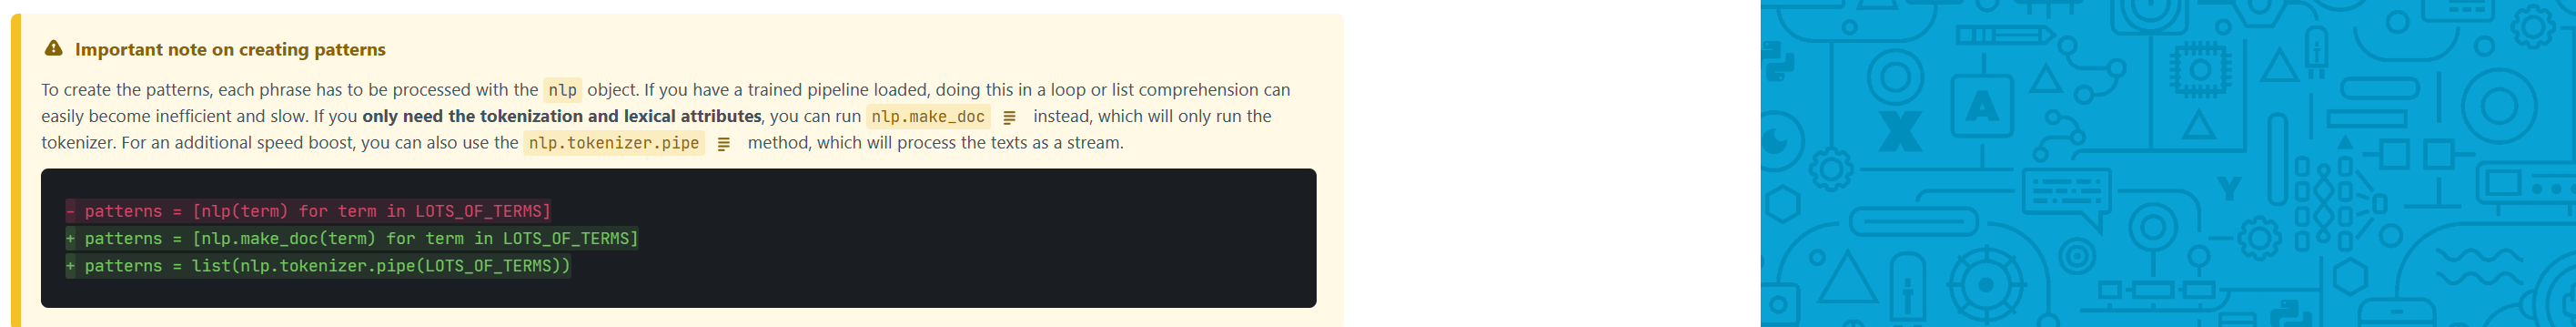

<h3>Matching on other token attributes</h3>

By default, the PhraseMatcher will match on the verbatim token text, e.g. Token.text. By setting the attr argument on initialization, you can change which token attribute the matcher should use when comparing the phrase pattern to the matched Doc. For example, using the attribute LOWER lets you match on Token.lower and create case-insensitive match patterns:

In [ ]:
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher

nlp = English()
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(name) for name in ["Angela Merkel", "Barack Obama"]]
matcher.add("Names", patterns)

doc = nlp("angela merkel and us president barack Obama")
for match_id, start, end in matcher(doc):
    print("Matched based on lowercase token text:", doc[start:end])

Another possible use case is matching number tokens like IP addresses based on their shape. This means that you won’t have to worry about how those strings will be tokenized and you’ll be able to find tokens and combinations of tokens based on a few examples. Here, we’re matching on the shapes ddd.d.d.d and ddd.ddd.d.d:

In [ ]:
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher

nlp = English()
matcher = PhraseMatcher(nlp.vocab, attr="SHAPE")
matcher.add("IP", [nlp("127.0.0.1"), nlp("127.127.0.0")])

doc = nlp("Often the router will have an IP address such as 192.168.1.1 or 192.168.2.1.")
for match_id, start, end in matcher(doc):
    print("Matched based on token shape:", doc[start:end])

In theory, the same also works for attributes like POS. For example, a pattern nlp("I like cats") matched based on its part-of-speech tag would return a match for “I love dogs”. You could also match on boolean flags like IS_PUNCT to match phrases with the same sequence of punctuation and non-punctuation tokens as the pattern. But this can easily get confusing and doesn’t have much of an advantage over writing one or two token patterns.

## Dependency Matcher

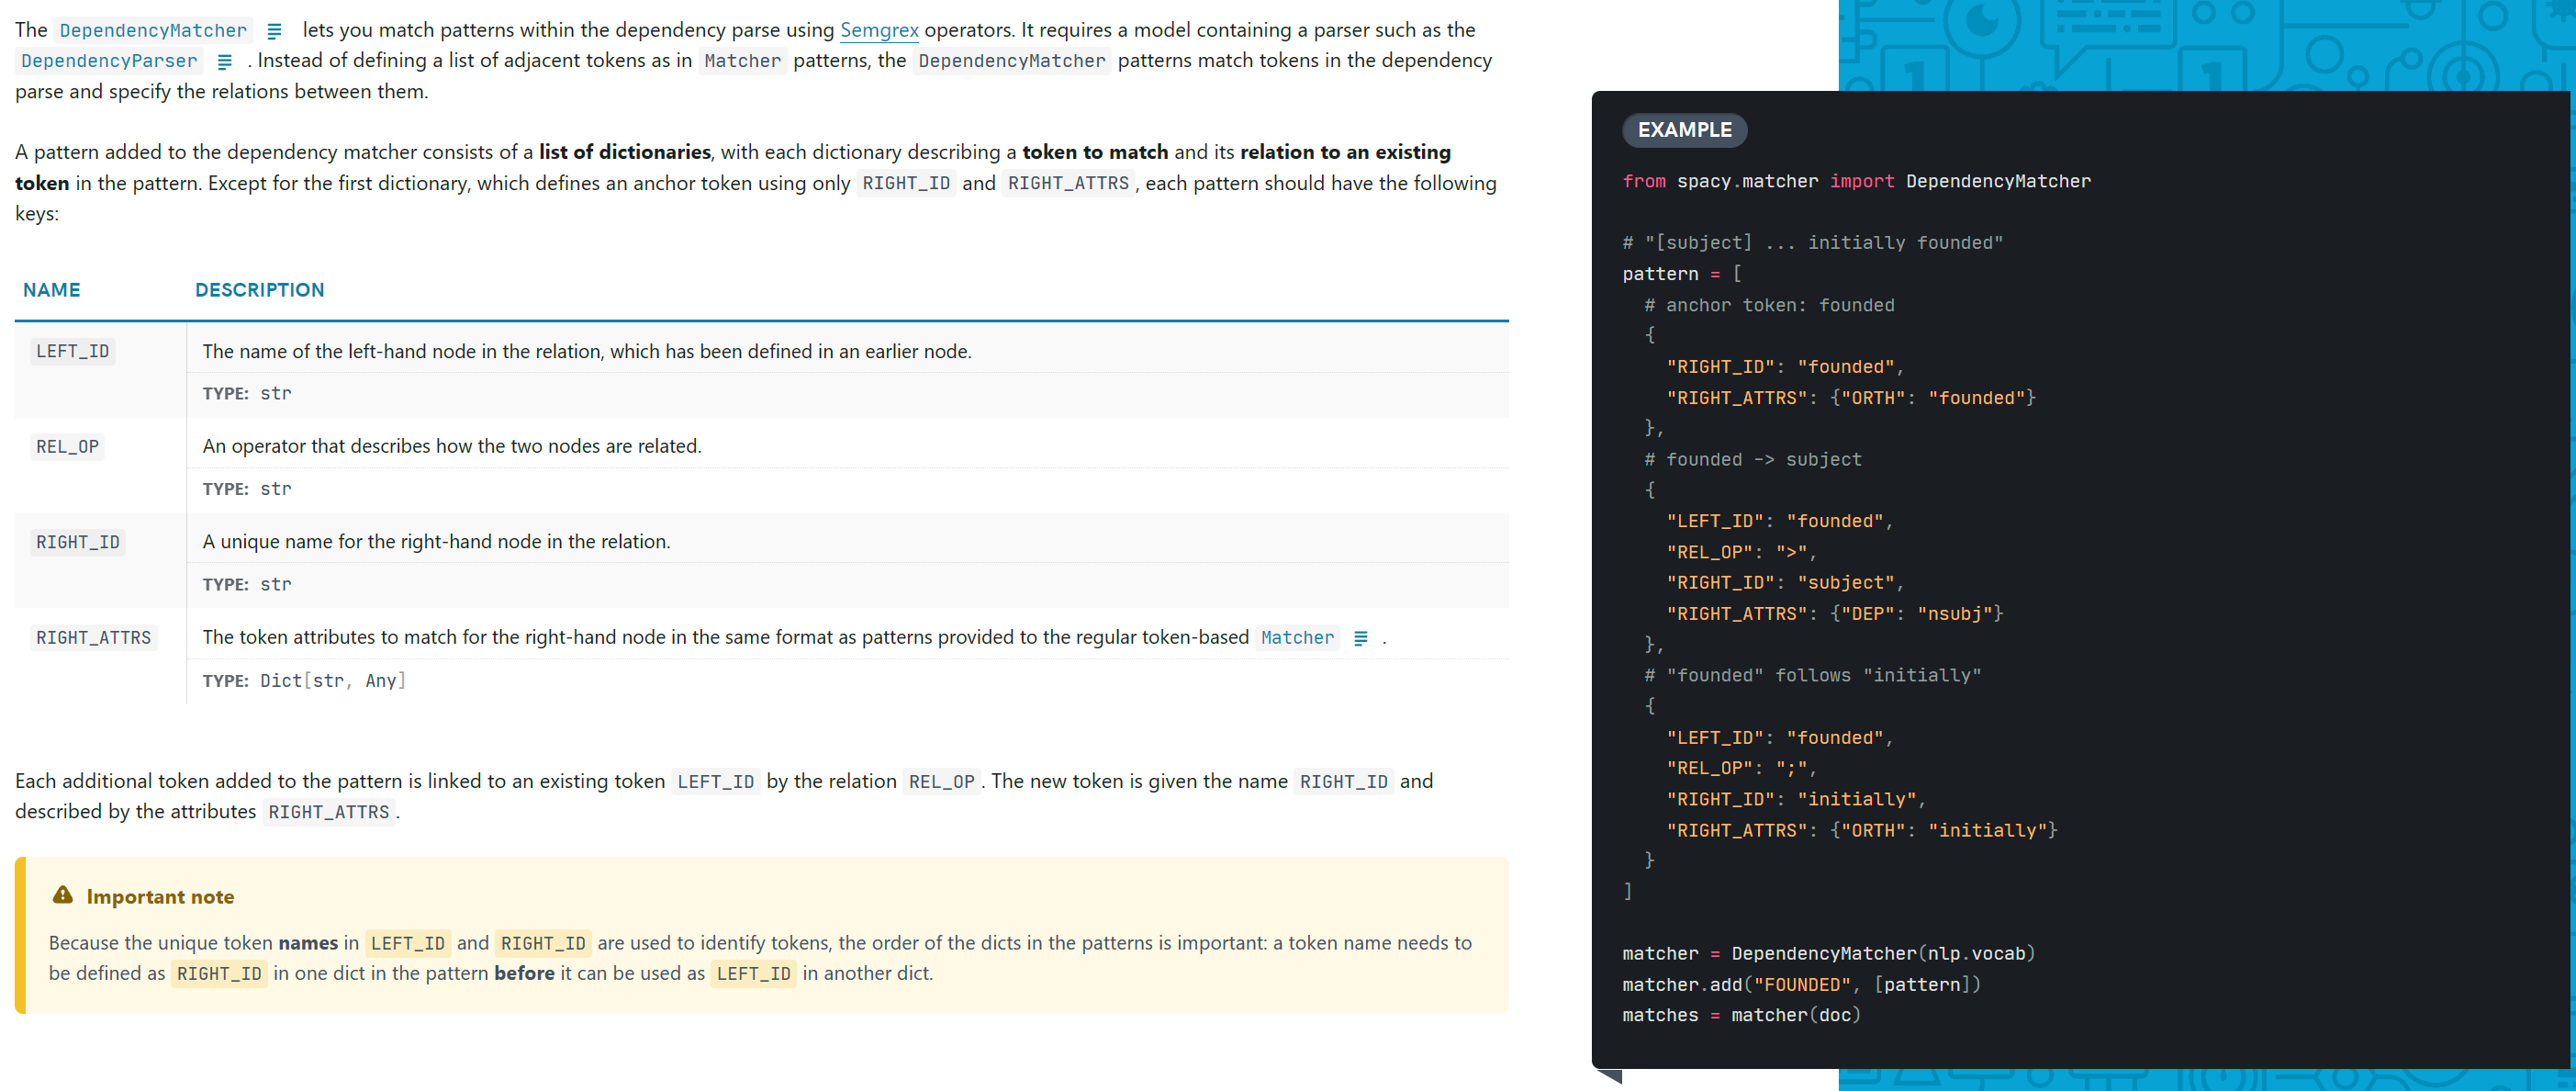

In [ ]:
from spacy.matcher import DependencyMatcher

# "[subject] ... initially founded"
pattern = [
  # anchor token: founded
  {
    "RIGHT_ID": "founded",
    "RIGHT_ATTRS": {"ORTH": "founded"}
  },
  # founded -> subject
  {
    "LEFT_ID": "founded",
    "REL_OP": ">",
    "RIGHT_ID": "subject",
    "RIGHT_ATTRS": {"DEP": "nsubj"}
  },
  # "founded" follows "initially"
  {
    "LEFT_ID": "founded",
    "REL_OP": ";",
    "RIGHT_ID": "initially",
    "RIGHT_ATTRS": {"ORTH": "initially"}
  }
]

matcher = DependencyMatcher(nlp.vocab)
matcher.add("FOUNDED", [pattern])
matches = matcher(doc)

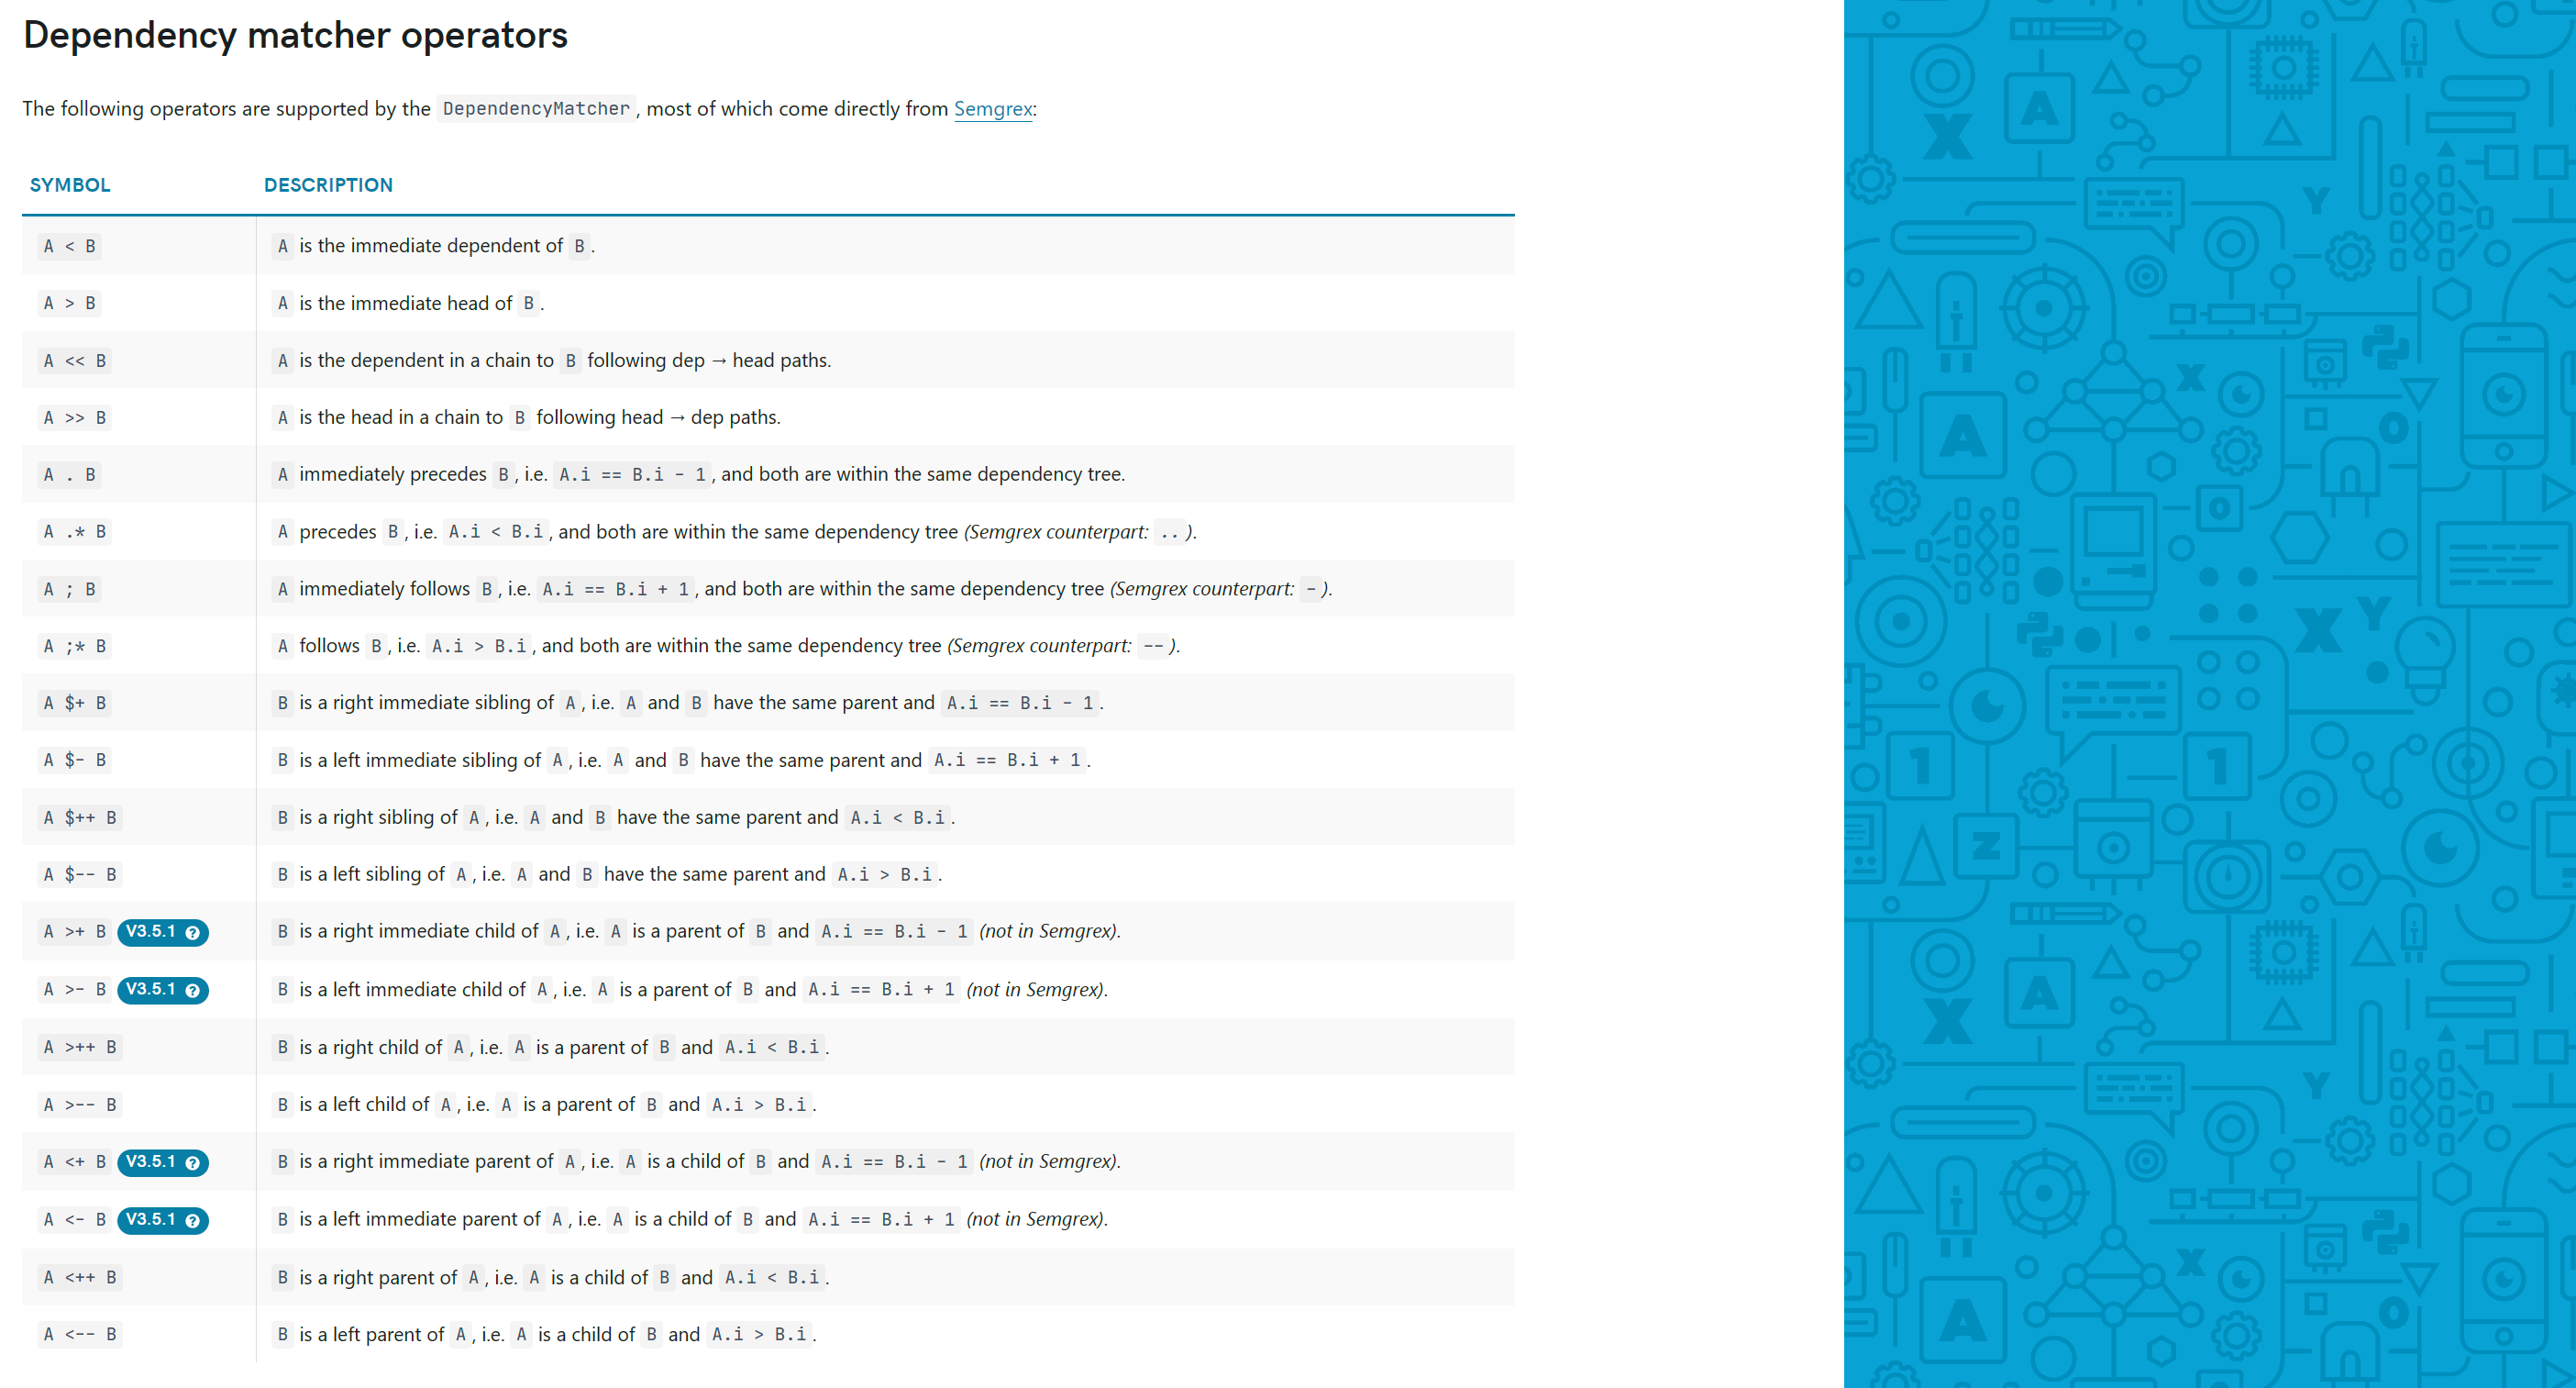

<h3>Designing dependency matcher patterns</h3>

Let’s say we want to find sentences describing who founded what kind of company:

    Smith founded a healthcare company in 2005.
    Williams initially founded an insurance company in 1987.
    Lee, an experienced CEO, has founded two AI startups.

The dependency parse for “Smith founded a healthcare company” shows types of relations and tokens we want to match:

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Smith founded a healthcare company")
displacy.render(doc)

The relations we’re interested in are:

- the founder is the subject (nsubj) of the token with the text founded
- the company is the object (dobj) of founded
- the kind of company may be an adjective (amod, not shown above) or a compound (compound)

The first step is to pick an <mark>anchor token</mark> for the pattern. Since it’s the root of the dependency parse, founded is a good choice here. It is often easier to construct patterns when all dependency relation operators point from the head to the children. In this example, we’ll only use >, which connects a head to an immediate dependent as head > child.

The simplest dependency matcher pattern will identify and name a single token in the tree:

In [ ]:
import spacy
from spacy.matcher import DependencyMatcher

nlp = spacy.load("en_core_web_sm")
matcher = DependencyMatcher(nlp.vocab)


In [ ]:
pattern = [
  {
    "RIGHT_ID": "anchor_founded",       # unique name
    "RIGHT_ATTRS": {"ORTH": "founded"}  # token pattern for "founded"
  }
]
matcher.add("FOUNDED", [pattern])


In [ ]:
doc = nlp("Smith founded two companies.")


In [ ]:
matches = matcher(doc)
print(matches) # [(4851363122962674176, [1])]

Now that we have a named anchor token (anchor_founded), we can add the founder as the immediate dependent (>) of founded with the dependency label nsubj:

In [ ]:
# STEP 1

pattern = [
    {
        "RIGHT_ID": "anchor_founded",
        "RIGHT_ATTRS": {"ORTH": "founded"}
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    }
    # ...
]

The direct object (dobj) is added in the same way:

In [ ]:
# STEP 2

pattern = [
    #...
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object",
        "RIGHT_ATTRS": {"DEP": "dobj"},
    }
    # ...
]

When the subject and object tokens are added, they are required to have names under the key RIGHT_ID, which are allowed to be any unique string, e.g. founded_subject. These names can then be used as LEFT_ID to link new tokens into the pattern. For the final part of our pattern, we’ll specify that the token founded_object should have a modifier with the dependency relation amod or compound:

In [ ]:
# STEP 3

pattern = [
    # ...
    {
        "LEFT_ID": "founded_object",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object_modifier",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "compound"]}},
    }
]

You can picture the process of creating a dependency matcher pattern as defining an anchor token on the left and building up the pattern by linking tokens one-by-one on the right using relation operators. To create a valid pattern, each new token needs to be linked to an existing token on its left. As for founded in this example, a token may be linked to more than one token on its right:


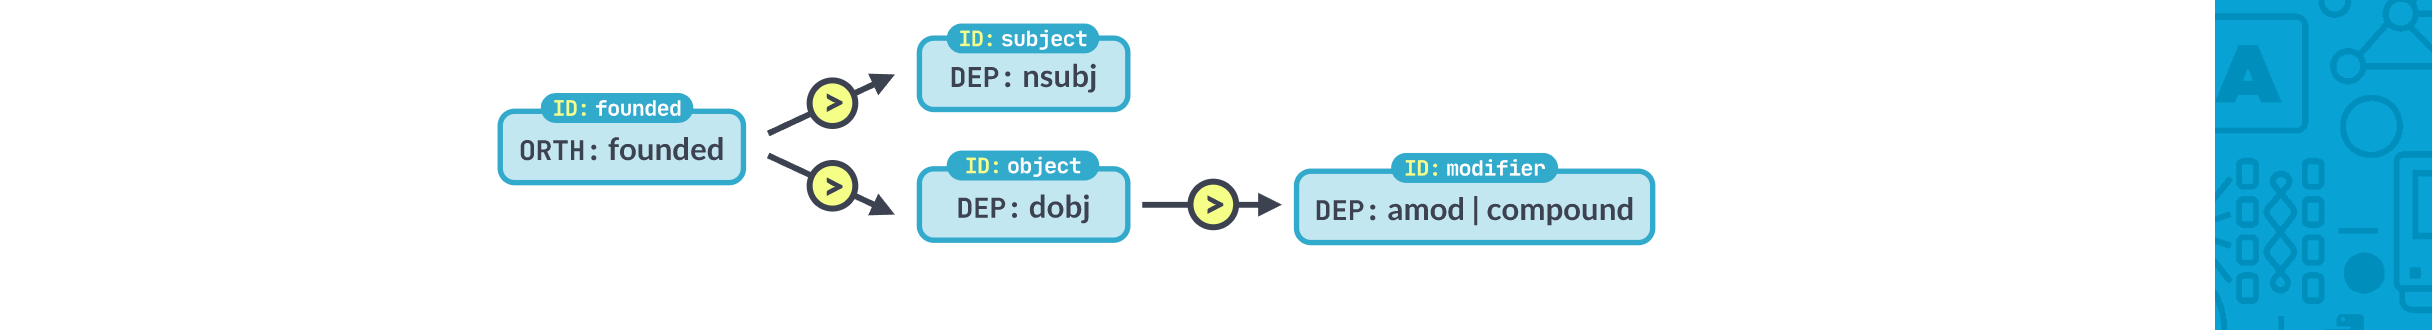


The full pattern comes together as shown in the example below:

In [5]:
import spacy
import pandas as pd
from spacy.matcher import DependencyMatcher
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
matcher = DependencyMatcher(nlp.vocab)

pattern = [
    {
        "RIGHT_ID": "anchor_founded",
        "RIGHT_ATTRS": {"ORTH": "founded"}
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object",
        "RIGHT_ATTRS": {"DEP": "dobj"},
    },
    {
        "LEFT_ID": "founded_object",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object_modifier",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "compound"]}},
    }
]

matcher.add("FOUNDED", [pattern])
doc = nlp("Lee, an experienced CEO, has founded two AI startups.")
matches = matcher(doc)

print(matches) # [(4851363122962674176, [6, 0, 10, 9])]
# Each token_id corresponds to one pattern dict
match_id, token_ids = matches[0]
for i in range(len(token_ids)):
    print(pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)

[(4851363122962674176, [7, 0, 10, 9])]
anchor_founded: founded
founded_subject: Lee
founded_object: startups
founded_object_modifier: AI


In [2]:
displacy.render(doc)

In [8]:
# POS Tagging
pos_tagging = pd.DataFrame(data=[], \
  columns=["id", "T_texto","T_lemma_", "T_pos_", "T_tag_", "T_dep_", "T_head", "T_is_sent_start", "T_shape_", "T_is_alpha", "T_is_stop"])
i = 0
for token in doc:
    pos_tagging.loc[i,"id"] = token.i
    pos_tagging.loc[i,"T_texto"] = token.text
    pos_tagging.loc[i,"T_lemma_"] = token.lemma_
    pos_tagging.loc[i,"T_pos_"] = token.pos_
    pos_tagging.loc[i,"T_tag_"] = token.tag_
    pos_tagging.loc[i,"T_dep_"] = token.dep_
    pos_tagging.loc[i,"T_head"] = token.head
    pos_tagging.loc[i,"T_is_sent_start"] = token.is_sent_start
    pos_tagging.loc[i,"T_shape_"] = token.shape_
    pos_tagging.loc[i,"T_is_alpha"] = token.is_alpha
    pos_tagging.loc[i,"T_is_stop"] = token.is_stop

    i = i+1

pos_tagging

,id,T_texto,T_lemma_,T_pos_,T_tag_,T_dep_,T_head,T_is_sent_start,T_shape_,T_is_alpha,T_is_stop
0,0,Lee,Lee,PROPN,NNP,nsubj,founded,True,Xxx,True,False
1,1,",",",",PUNCT,",",punct,Lee,False,",",False,False
2,2,an,an,DET,DT,det,CEO,False,xx,True,True
3,3,experienced,experienced,ADJ,JJ,amod,CEO,False,xxxx,True,False
4,4,CEO,ceo,NOUN,NN,appos,Lee,False,XXX,True,False
5,5,",",",",PUNCT,",",punct,Lee,False,",",False,False
6,6,has,have,AUX,VBZ,aux,founded,False,xxx,True,True
7,7,founded,found,VERB,VBN,ROOT,founded,False,xxxx,True,False
8,8,two,two,NUM,CD,nummod,startups,False,xxx,True,True
9,9,AI,AI,PROPN,NNP,compound,startups,False,XX,True,False


<h3>In Portuguese</h3>

In [ ]:
import spacy
import pandas as pd

from spacy import displacy
from spacy.tokens import Span
from spacy.matcher import Matcher

from spacy.matcher import PhraseMatcher
from spacy.matcher import DependencyMatcher # Estamos trabalhando com o dependency Matcher

nlp = spacy.load("pt_core_news_sm")
matcher = DependencyMatcher(nlp.vocab)

In [ ]:
print("Pipeline:", nlp.pipe_names)

In [ ]:
nlp.analyze_pipes(pretty=True)

In [ ]:
pattern = [
  {
    "RIGHT_ID": "anchor_saber",       # unique name
    "RIGHT_ATTRS": {"ORTH": "saber"}  # token pattern for "founded"
  }
]
matcher.add("SABER", [pattern])


In [ ]:
doc = nlp("Quero saber quais são meus contratos com a fazenda Santa Rita?")

In [ ]:
matches = matcher(doc)
print(matches) # [(4851363122962674176, [1])]

In [ ]:
# POS Tagging
pos_tagging = pd.DataFrame(data=[], \
  columns=["id", "T_texto","T_lemma_", "T_pos_", "T_tag_", "T_dep_", "T_head", "T_is_sent_start", "T_shape_", "T_is_alpha", "T_is_stop"])
i = 0
for token in doc:
    pos_tagging.loc[i,"id"] = token.i
    pos_tagging.loc[i,"T_texto"] = token.text
    pos_tagging.loc[i,"T_lemma_"] = token.lemma_
    pos_tagging.loc[i,"T_pos_"] = token.pos_
    pos_tagging.loc[i,"T_tag_"] = token.tag_
    pos_tagging.loc[i,"T_dep_"] = token.dep_
    pos_tagging.loc[i,"T_head"] = token.head
    pos_tagging.loc[i,"T_is_sent_start"] = token.is_sent_start
    pos_tagging.loc[i,"T_shape_"] = token.shape_
    pos_tagging.loc[i,"T_is_alpha"] = token.is_alpha
    pos_tagging.loc[i,"T_is_stop"] = token.is_stop

    i = i+1

pos_tagging

In [ ]:
displacy.render(doc)

In [ ]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)

In [ ]:
pattern = [
    {
        "RIGHT_ID": "anchor_founded",
        "RIGHT_ATTRS": {"ORTH": "founded"}
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object",
        "RIGHT_ATTRS": {"DEP": "dobj"},
    },
    {
        "LEFT_ID": "founded_object",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object_modifier",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "compound"]}},
    }
]

matcher.add("FOUNDED", [pattern])
doc = nlp("Lee, an experienced CEO, has founded two AI startups.")
matches = matcher(doc)

print(matches) # [(4851363122962674176, [6, 0, 10, 9])]
# Each token_id corresponds to one pattern dict
match_id, token_ids = matches[0]
for i in range(len(token_ids)):
    print(pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)

<h3>Efetuando testes e comparaÇoes</h3>

<h3>Adding patterns</h3>

In [ ]:
from spacy.vocab import Vocab
vocab = Vocab(strings=["hello", "world"])

In [ ]:
len(vocab)

### Matcher pattern

Acessar template de criaçao de matcher 

In [ ]:
import spacy
import pandas as pd
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

In [ ]:
patterns = [
    [{"LOWER": "hello"}, {"IS_PUNCT": True}, {"LOWER": "world"}],
    [{"LOWER": "hello"}, {"LOWER": "world"}]
]

matcher.add("hello", patterns)

In [ ]:
matcher.add("hello", [patterns])

In [ ]:
doc = nlp("Hello world! Hello world and hello 2 world!")

In [ ]:
matches = matcher(doc)

In [ ]:
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id] # get the string representation
    span = doc[start:end] # The matcher span
    print(match_id, string_id, start, end, span.text)

Algumas conferencias

In [ ]:
len(matcher)

In [ ]:
[(token.i, token.text, token.pos_, token.tag_) for token in doc]

## Mapping & exceptions

### In English

In [ ]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")
text = "I saw The Who perform. Who did you see?"
doc1 = nlp(text)

In [ ]:
tokens_to_check = [2, 3, 6]

In [ ]:
doc = doc1
print(doc)
text_ruler = pd.DataFrame(data=[], \
  columns=["T_idx", "T_texto","T_Tag_", "T_Tag_explained", "T_pos_", "T_pos_explained"])
i = 0
for idx in tokens_to_check:
    text_ruler.loc[i,"T_idx"] = doc[idx].i
    text_ruler.loc[i,"T_texto"] = doc[idx].text
    text_ruler.loc[i,"T_Tag_"] = doc[idx].tag_
    text_ruler.loc[i,"T_Tag_explained"] = spacy.explain(doc[idx].tag_)
    text_ruler.loc[i,"T_pos_"] = doc[idx].pos_
    text_ruler.loc[i,"T_pos_explained"] = spacy.explain(doc[idx].pos_)
 
    
    i = i+1
text_ruler

>OK?

In [ ]:
# Add attribute ruler with exception for "The Who" as NNP/PROPN NNP/PROPN
ruler = nlp.get_pipe("attribute_ruler")

In [ ]:
# Pattern to match "The Who"
patterns = [[{"LOWER": "the"}, {"TEXT": "Who"}]]
# The attributes to assign to the matched token
attrs = {"TAG": "NNP", "POS": "PROPN"}
# Add rules to the attribute ruler

In [ ]:
ruler.add(patterns=patterns, attrs=attrs, index=0)  # "The" in "The Who"
ruler.add(patterns=patterns, attrs=attrs, index=1)  # "Who" in "The Who"

In [ ]:
doc2 = nlp(text)

In [ ]:
doc = doc2
print(doc)
text_ruler = pd.DataFrame(data=[], \
  columns=["T_idx", "T_texto","T_Tag_", "T_Tag_explained", "T_pos_", "T_pos_explained"])
i = 0
for idx in tokens_to_check:
    text_ruler.loc[i,"T_idx"] = doc[idx].i
    text_ruler.loc[i,"T_texto"] = doc[idx].text
    text_ruler.loc[i,"T_Tag_"] = doc[idx].tag_
    text_ruler.loc[i,"T_Tag_explained"] = spacy.explain(doc[idx].tag_)
    text_ruler.loc[i,"T_pos_"] = doc[idx].pos_
    text_ruler.loc[i,"T_pos_explained"] = spacy.explain(doc[idx].pos_)
 
    
    i = i+1
text_ruler

### In Portuguese

In [ ]:
import spacy
import pandas as pd

nlp = spacy.load("pt_core_news_lg")


In [ ]:
text = "A Santa Rita é muito famosa em Santa Rita."
doc1 = nlp(text)

In [ ]:
[(token.i, token.text) for token in doc1]

In [ ]:
tokens_to_check = [0, 1, 2, 6, 7, 8]

tokens_to_check


In [ ]:
doc = doc1
print(doc)
text_ruler = pd.DataFrame(data=[], \
  columns=["T_idx", "T_texto","T_Tag_", "T_Tag_explained", "T_pos_", "T_pos_explained"])
i = 0
for idx in tokens_to_check:
    text_ruler.loc[i,"T_idx"] = doc[idx].i
    text_ruler.loc[i,"T_texto"] = doc[idx].text
    text_ruler.loc[i,"T_Tag_"] = doc[idx].tag_
    text_ruler.loc[i,"T_Tag_explained"] = spacy.explain(doc[idx].tag_)
    text_ruler.loc[i,"T_pos_"] = doc[idx].pos_
    text_ruler.loc[i,"T_pos_explained"] = spacy.explain(doc[idx].pos_)
    doc[idx].ent_id
 
    
    i = i+1
text_ruler

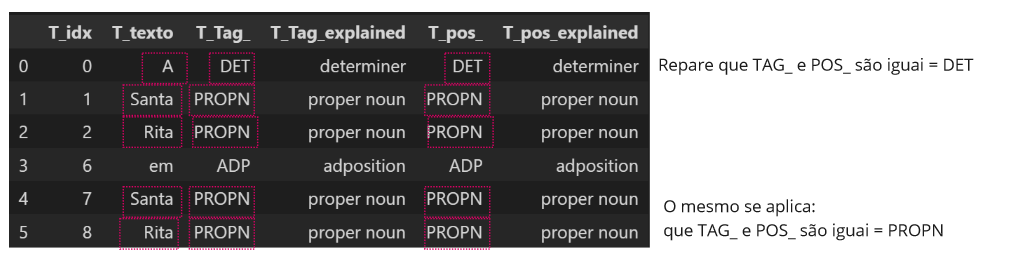

>OK?

In [ ]:
# Add attribute ruler with exception for "A Santa Rita" as NNP/PROPN NNP/PROPN
ruler = nlp.get_pipe("attribute_ruler")

In [ ]:
# Pattern to match "A Santa Rita"
patterns = [[{"TEXT": "A"}, {"TEXT": "Santa"}, {"TEXT": "Rita"}]]
# The attributes to assign to the matched token
attrs = {"TAG": "NNP", "POS": "PROPN"}
# Add rules to the attribute ruler

In [ ]:
# Add rules to the attribute ruler
ruler.add(patterns=patterns, attrs=attrs, index=0)  # "A" em "A Santa Rita"
ruler.add(patterns=patterns, attrs=attrs, index=1)  # "Santa" em "A Santa Rita"
ruler.add(patterns=patterns, attrs=attrs, index=2)  # "Rita" em "A Santa Rita"

In [ ]:
doc2 = nlp(text)

In [ ]:
doc = doc2
print(doc)
text_ruler = pd.DataFrame(data=[], \
  columns=["T_idx", "T_texto","T_Tag_", "T_Tag_explained", "T_pos_", "T_pos_explained"])
i = 0
for idx in tokens_to_check:
    text_ruler.loc[i,"T_idx"] = doc[idx].i
    text_ruler.loc[i,"T_texto"] = doc[idx].text
    text_ruler.loc[i,"T_Tag_"] = doc[idx].tag_
    text_ruler.loc[i,"T_Tag_explained"] = spacy.explain(doc[idx].tag_)
    text_ruler.loc[i,"T_pos_"] = doc[idx].pos_
    text_ruler.loc[i,"T_pos_explained"] = spacy.explain(doc[idx].pos_)
 
    
    i = i+1
text_ruler

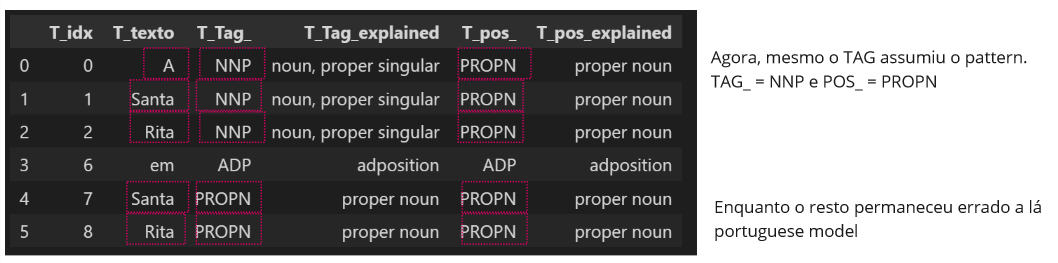

### Important note

Pipeline packages that come with built-in word vectors make them available as the Token.vector attribute. Doc.vector and Span.vector will default to an average of their token vectors. You can also check if a token has a vector assigned, and get the L2 norm, which can be used to normalize vectors.

<h3>en_core_web_sm</h3>

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
nlp.analyze_pipes(pretty=True)

<h3>en_core_web_md</h3>

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
nlp.analyze_pipes(pretty=True)

<h3>en_core_web_lg</h3>

In [ ]:
import spacy

nlp = spacy.load("en_core_web_lg")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
nlp.analyze_pipes(pretty=True)

<h3>en_core_web_trf</h3>

In [ ]:
import spacy

nlp = spacy.load("en_core_web_trf")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
nlp.analyze_pipes(pretty=True)

### Em Portugues

In [ ]:
import spacy

nlp = spacy.load("pt_core_news_sm")
tokens = nlp("cachorro gato banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
nlp.analyze_pipes(pretty=True)

In [ ]:
import spacy

nlp = spacy.load("pt_core_news_lg")
tokens = nlp("cachorro gato banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
nlp.analyze_pipes(pretty=True)

## Similaridade

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")  # make sure to use larger package!


In [ ]:
doc1 = nlp("I like salty fries and hamburgers.")
doc2 = nlp("Fast food tastes very good.")

In [ ]:
# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))
# Similarity of tokens and spans
french_fries = doc1[2:4]
burgers = doc1[5]
print(french_fries, "<->", burgers, french_fries.similarity(burgers))

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
nlp.analyze_pipes(pretty=True)

In [ ]:
from spacy.matcher import DependencyMatcher

# "[subject] ... initially founded"
pattern = [
  # anchor token: founded
  {
    "RIGHT_ID": "founded",
    "RIGHT_ATTRS": {"ORTH": "founded"}
  },
  # founded -> subject
  {
    "LEFT_ID": "founded",
    "REL_OP": ">",
    "RIGHT_ID": "subject",
    "RIGHT_ATTRS": {"DEP": "nsubj"}
  },
  # "founded" follows "initially"
  {
    "LEFT_ID": "founded",
    "REL_OP": ";",
    "RIGHT_ID": "initially",
    "RIGHT_ATTRS": {"ORTH": "initially"}
  }
]

matcher = DependencyMatcher(nlp.vocab)
matcher.add("FOUNDED", [pattern])
matches = matcher(doc)

### Designing dependency matcher patterns

Let’s say we want to find sentences describing who founded what kind of company:

Smith founded a healthcare company in 2005.
Williams initially founded an insurance company in 1987.
Lee, an experienced CEO, has founded two AI startups.

<mark>Important note on speed</mark>

The dependency matcher may be slow when token patterns can potentially match many tokens in the sentence or when relation operators allow longer paths in the dependency parse, e.g. <<, >>, .* and ;*.

To improve the matcher speed, try to make your token patterns and operators as specific as possible. For example, **use > instead of >>** if possible and use token patterns that include dependency labels and other token attributes instead of patterns such as {} that match any token in the sentence.

In [ ]:
seq_tokens_valued = []
for token in doc1:
    seq_tokens_valued.append(token.i)

In [ ]:
[(token.i, token.text, token.tag_, token.pos_) for token in doc2]

In [ ]:
print(doc1[2].text, doc1[2].tag_, doc1[2].pos_)  # DT DET
print(doc1[3].text, doc1[3].tag_, doc1[3].pos_)  # WP PRON

In [ ]:
print(doc1[2].text, doc1[2].tag_, doc1[2].pos_)  # DT DET
print(doc1[3].text, doc1[3].tag_, doc1[3].pos_)  # WP PRON
# The second "Who" remains unmodified
print(doc2[6].text, doc2[6].tag_, doc2[6].pos_)  # WP PRON